In [1]:
import scanpy as sc
import scanpy.external as sce

import pandas as pd
import scipy
import anndata
from scanpy.external.pp import magic
import cytopus as cp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
working_dir ='/path_to_data/'

In [3]:
import seaborn as sns

In [4]:
def overlap_coefficient(set_a,set_b):
    min_len = min([len(set_a),len(set_b)])
    intersect_len = len(set_a.intersection(set_b))
    overlap = intersect_len/min_len
    return overlap


In [5]:
def randomize_cells(anndata_object):
    "Randomize cells for plotting "
    index_list = np.arange(anndata_object.shape[0])
    np.random.shuffle(index_list)
    anndata_object = anndata_object[index_list]
    return anndata_object

In [6]:
def aggregate_cell_scores(adata,clinical_var_obs,clinical_var2_obs,factor_name_list_corr,batch_key,patient_obs,
                            obs_columns,
                            zero_cutoff =0.001):
    '''
    aggregate factor cell scores per batch/patient:
    clinical_var_obs: for later fold change calculation --> #obs for clinical variable to calculate fold change over
    clinical_var2_obs #additional clinical variable
    patient_obs #key for patient id in adata.obs 
    batch_key #key for batch / sample in adata.obs
    factor_name_list_corr #list with factors to calculate fold change for
    zero_cutoff #mean of positive fraction per factor will be calculated, define threshold for positive frac if None mean without any cutoff will be calculated 
     obs_columns: name for columns in output dataframe (order will be clinical_var_obs, clinical_var2_obs, partient_obs)
    '''
    #first calculate mean of positive fraction for each sample
    df_batches = pd.DataFrame()

    for j in set(adata.obs[batch_key]):
        adata_subset = adata[adata.obs[batch_key]==j]
        clinical_var = list(set(adata_subset.obs[clinical_var_obs]))[0]
        clinical_var2 = list(set(adata_subset.obs[clinical_var2_obs]))[0]
        patient = list(set(adata_subset.obs[patient_obs]))[0]

        #define here which metric you want to use
        for i in factor_name_list_corr:
            if zero_cutoff == None:
                a = np.mean(adata_subset.obs[i])
            else:
                a = np.mean(adata_subset.obs[adata_subset.obs[i] >zero_cutoff][i])
            #a = np.mean(adata_CD8_pre.obs[i])

            df_batches.loc[j,i]=a
            df_batches.loc[j,obs_columns[0]] = clinical_var
            df_batches.loc[j,obs_columns[1]] = clinical_var2
            df_batches.loc[j,obs_columns[2]] = patient
    

    return df_batches


In [7]:
#calculate and select PC number
def calculate_optimal_PC(adata, min_PC = 50, min_var=25, n_comps=100, use_hv=None):
    'select number of PCs based on min_PC and min_var threshold'
    import matplotlib.pyplot as plt
    import scanpy as sc
    from kneed import KneeLocator

    #calculate PCs
    sc.tl.pca(adata, n_comps=100, zero_center=True, svd_solver='arpack', random_state=0, return_info=False, use_highly_variable=use_hv, dtype='float32', copy=False, chunked=False, chunk_size=None)
    sc.pl.pca_variance_ratio(adata, log=False)

    #calculate number of PCs

    a = adata.copy()# PCs kneepoint
    x = [i for i in range(len(a.uns["pca"]["variance_ratio"]))]
    y = list(a.uns["pca"]["variance_ratio"])
    kneedle = KneeLocator(x,
                      y,
                      S=1,
                      curve='convex',
                      direction='decreasing',
                      online=False)
    kn_pc = round(kneedle.knee, 3)
    kneedle.plot_knee()
    plt.show()
    kneedle.plot_knee_normalized()
    plt.show()
    print("Kneepoint happens at PC:", kn_pc)

    exp_var = sum(adata.uns['pca']['variance_ratio'][:kn_pc])
    exp_var_test_percent = exp_var*100
    print(kn_pc,'PC explain',exp_var_test_percent, '% of variance')

    #find number of PCs explaining at least min variance
    tested_PC_number = kn_pc



    tested_PC_number = 1
    while exp_var_test_percent <min_var:
        tested_PC_number = tested_PC_number+1
        exp_var_test = sum(adata.uns['pca']['variance_ratio'][0:tested_PC_number])
        exp_var_test_percent = exp_var_test*100
        print(tested_PC_number, 'PC explain',exp_var_test_percent, '% of variance')
        if tested_PC_number == n_comps:
            break

            
    exp_var_test = sum(adata.uns['pca']['variance_ratio'][0:min_PC])
    exp_var_test_percent = exp_var_test*100
    if tested_PC_number <min_PC:
        print('setting PCs to',min_PC)
        print('variance of',min_PC,'is',exp_var_test_percent,'%')
        tested_PC_number = min_PC
        
        
    #define PC number for embeddings
    number_of_PC_used = tested_PC_number
    
    exp_var_test = sum(adata.uns['pca']['variance_ratio'][0:tested_PC_number])
    exp_var_test_percent = exp_var_test*100
    print('number of PCs for clusterings/embeddings is:', number_of_PC_used)
    print('these explain', exp_var_test_percent,'of variance') 
    
    #recalculate PCs
    sc.pp.pca(adata, n_comps=number_of_PC_used, zero_center=True, svd_solver='arpack', random_state=0, return_info=False, use_highly_variable=use_hv, dtype='float32', copy=False, chunked=False, chunk_size=None)
    sc.pl.pca_variance_ratio(adata, log=False)
    return number_of_PC_used

In [8]:
DATA_DIR = '/path_to_data/'
fig_save_path ='/path_to_figures/'

In [9]:
color_map_clusters_nogrey = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
"#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
"#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
"#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
"#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
"#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
"#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
"#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
"#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
"#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
"#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
"#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C"]

batlow_20 = ['#1d2356','#1d2b59',
'#14375e',
'#134460',
'#1c5261',
'#235f5f',
'#396a58',
'#4c714e',
'#607843',
'#757e36',
'#8d8532',
'#a78b30',
'#c49138',
'#dc954d',
'#f09c6a',
'#f8a487',
'#f8aca2',
'#f8b5be',
'#f8c2d9',
'#eecbe1'] 
import random
random.seed(1)
random.shuffle(batlow_20)

blue_red = ['#0E518F','#DF480F']


# data 

In [52]:
import scanpy as sc

In [10]:
#adata_path = DATA_DIR+ 'PBMC-X-NA-X-Kartha-X-scRNAseq-X-10.1016_j.xgen.2022.100166_normalized_clustered_10000hv_batch_annotated_Spectra_lambda0.001_lambda0.001_rho0.05_kappaNone_delta0.001.h5ad'
#adata_path = DATA_DIR+ 'PBMC-X-NA-X-Kartha-X-scRNAseq-X-10.1016_j.xgen.2022.100166_normalized_clustered_10000hv_batch_annotated_Spectra_lambda0.01_lambda0.01_rho0.05_kappaNone_delta0.001.h5ad'
adata_path = DATA_DIR+ 'PBMC-X-NA-X-Kartha-X-scRNAseq-X-10.1016_j.xgen.2022.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito_lambda0.01_lambda0.01_rho0.05_kappaNone_delta0.001.h5ad'


In [11]:
adata = sc.read(adata_path)
adata

Only considering the two last: ['.001', '.h5ad'].
Only considering the two last: ['.001', '.h5ad'].


AnnData object with n_obs × n_vars = 23754 × 19004
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'spectra_vocab'
    uns: 'SPECTRA_L', 'SPECTRA_factors', 'SPECTRA_markers', 'annotation_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'pheno_var_k40_colors', 'tsne', 'umap'
    obsm: 'SPECTRA_cell_scores', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'imputed', 'raw'
    obsp: 'connectivities', 'distances'

In [12]:
#get gene sets from cytopus package
import cytopus
G = cytopus.kb.KnowledgeBase()

KnowledgeBase object containing 75 cell types and 201 cellular processes



In [13]:
adata.uns['SPECTRA_markers'].shape

(196, 100)

In [14]:
#label factors by their overlap coefficient with input gene sets
overlap_df = cp.tl.label_marker_genes(adata.uns['SPECTRA_markers'], G.processes, threshold = 0.2)
overlap_df

,lung-epi_IL4_response,all_carnitine-shuttle,fibro_IGF1_response,p-DC_CpG-TLR9_response,all_autophagy_regulation_positive,B_IL2_response,all_SASP,all_fatty-acid-beta-oxidation-mitochondrial,all_PI3K-AKT-mTOR_signaling,all_eicosanoid_metabolism,...,all_amino-sugar-nucleotide-sugar_metabolism,all_GLU_metabolism,all_pentose-phosphate-pathway,all_galactose_metabolism,all_Beta-Ala_metabolism,DC_CD40L_response,Mac_LPS_response,all_autophagy-chaperone-mediated,all_nucleotide_metabolism,all_CYS_metabolism
all_pyrimidine_metabolism,0.01,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.000000,...,0.00,0.0,0.0,0.0,0.142857,0.000000,0.000000,0.0000,0.115385,0.0
all_ros_response,0.00,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.000000,...,0.00,0.0,0.1,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.0
all_autophagic-cell-death,0.00,0.0,0.00,0.000000,0.07,0.052632,0.000000,0.0,0.12,0.000000,...,0.05,0.0,0.0,0.0,0.000000,0.011905,0.013514,0.0000,0.000000,0.0
all_DNA-methylation,0.01,0.0,0.01,0.000000,0.01,0.000000,0.000000,0.0,0.01,0.000000,...,0.00,0.0,0.0,0.0,0.000000,0.000000,0.027027,0.0000,0.038462,0.0
all_eicosanoid_metabolism,0.04,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.815789,...,0.00,0.0,0.0,0.0,0.000000,0.023810,0.000000,0.0625,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CD8-T_terminal-exhaustion,0.03,0.0,0.01,0.285714,0.00,0.052632,0.000000,0.0,0.02,0.000000,...,0.00,0.0,0.0,0.0,0.000000,0.095238,0.000000,0.0000,0.000000,0.0
CD8-T_IL12_response,0.02,0.0,0.02,0.285714,0.03,0.000000,0.000000,0.0,0.00,0.000000,...,0.00,0.0,0.0,0.0,0.000000,0.011905,0.013514,0.0000,0.000000,0.0
Treg_FoxP3-stabilization,0.01,0.0,0.00,0.142857,0.01,0.052632,0.014925,0.0,0.02,0.000000,...,0.00,0.0,0.0,0.0,0.000000,0.035714,0.013514,0.0000,0.000000,0.0
194,0.02,0.0,0.00,0.142857,0.01,0.052632,0.014925,0.0,0.04,0.000000,...,0.00,0.0,0.0,0.0,0.000000,0.023810,0.027027,0.0000,0.000000,0.0


In [15]:
#add index to make labels unique
new_index =[]
for h,i in enumerate(overlap_df.index):
    new_index.append(str(h)+'-X-'+str(i))
    
overlap_df.index = new_index

In [16]:
#label factors in the cell scores dataframe
adata.obsm['SPECTRA_cell_scores_df'] = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'],columns=overlap_df.index,index=adata.obs_names)

In [17]:
#add cell score to adata.obs (just for easier plotting)
for i in adata.obsm['SPECTRA_cell_scores_df'].columns:
    adata.obs[i] = list(adata.obsm['SPECTRA_cell_scores_df'][i])
    

/scratch/lsftmp/17664867.tmpdir/ipykernel_456258/2273363911.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[i] = list(adata.obsm['SPECTRA_cell_scores_df'][i])
/scratch/lsftmp/17664867.tmpdir/ipykernel_456258/2273363911.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[i] = list(adata.obsm['SPECTRA_cell_scores_df'][i])
/scratch/lsftmp/17664867.tmpdir/ipykernel_456258/2273363911.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

In [18]:
#Spectra factor overlap with the ifn type II response input gene set
overlap_df['all_type-II-ifn-response'].sort_values()

0-X-all_pyrimidine_metabolism     0.000000
106-X-all_hypoxia-response        0.000000
107-X-all_urea-cycle              0.000000
108-X-all_n-glycan_synthesis      0.000000
111-X-all_JAK-STAT_signaling      0.000000
                                    ...   
163-X-mast_granule-exocytosis     0.235294
157-X-all_MHC-I-presentation      0.294118
154-X-B_IL2_response              0.294118
151-X-B_Breg_UP                   0.470588
101-X-all_type-II-ifn-response    0.882353
Name: all_type-II-ifn-response, Length: 196, dtype: float64

In [19]:
#Spectra factor overlap with the TCR activation input gene set
overlap_df['T_tcr-activation'].sort_values()

0-X-all_pyrimidine_metabolism              0.000000
108-X-all_n-glycan_synthesis               0.000000
102-X-all_actin-cytoskeleton_regulation    0.000000
101-X-all_type-II-ifn-response             0.000000
100-X-all_riboflavin_metabolism            0.000000
                                             ...   
48-X-all_TNF-via-NFkB_signaling            0.136364
155-X-B_effector-2_UP                      0.136364
184-X-CD4-T_TH1_UP                         0.151515
187-X-CD4-T_TH22_UP                        0.166667
180-X-T_tcr-activation                     0.984848
Name: T_tcr-activation, Length: 196, dtype: float64

In [19]:
#Spectra factor overlap with the LPS stimulation input gene set
overlap_df['Mac_LPS-IFNG_invitro_response'].sort_values()

0-X-all_pyrimidine_metabolism          0.000000
93-X-all_HIS_metabolism                0.000000
94-X-all_ketone-body_metabolism        0.000000
95-X-all_glycogenolysis                0.000000
169-X-Mac_IL4-IL13_response            0.000000
                                         ...   
164-X-DC_CD40L_response                0.238095
111-X-all_JAK-STAT_signaling           0.285714
45-X-all_IL6-JAK-STAT3_signaling       0.333333
50-X-all_SASP                          0.333333
170-X-Mac_LPS-IFNG_invitro_response    0.904762
Name: Mac_LPS-IFNG_invitro_response, Length: 196, dtype: float64

In [20]:
#select spectra factors matching perturbation 
factors_of_interest =['170-X-Mac_LPS-IFNG_invitro_response','180-X-T_tcr-activation','101-X-all_type-II-ifn-response']
factors_of_interest

['170-X-Mac_LPS-IFNG_invitro_response',
 '180-X-T_tcr-activation',
 '101-X-all_type-II-ifn-response']

In [21]:
#add celltype annotation to cell scores to determine factor cell type specificity
adata.obsm['SPECTRA_cell_scores_df']['celltype'] = list(adata.obs['annotation'])
adata.obsm['SPECTRA_cell_scores_df']

,0-X-all_pyrimidine_metabolism,1-X-all_ros_response,2-X-all_autophagic-cell-death,3-X-all_DNA-methylation,4-X-all_eicosanoid_metabolism,5-X-all_MHC-I-presentation,6-X-all_bile-acid_synthesis,7-X-all_MHC-II-presentation,8-X-Treg_FoxP3-stabilization,9-X-all_heparan-sulfate_degradation,...,187-X-CD4-T_TH22_UP,188-X-CD4-T_IL12_response,189-X-CD4-T_TH9_UP,190-X-CD8-T_tumor-reactive-like_UP,191-X-CD8-T_terminal-exhaustion,192-X-CD8-T_IL12_response,193-X-Treg_FoxP3-stabilization,194-X-194,195-X-195,celltype
cellBarcode,,,,,,,,,,,,,,,,,,,,,
Control_1h_Donor1_tgcgagcgtgcattattgcct,1.949257e-05,1.184196e-04,1.120416e-04,6.398171e-12,4.922672e-05,3.866349e-04,1.390324e-05,5.786822e-05,7.973750e-05,5.798636e-04,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,M
Control_1h_Donor1_cgatgcaggcaggctttggtc,1.510175e-04,5.465823e-05,1.775909e-05,1.041431e-04,1.239571e-04,4.962813e-04,6.512042e-05,8.478251e-05,8.407258e-05,9.883091e-05,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,M
Control_1h_Donor1_cgacactagaccatccaagct,8.201473e-12,2.926696e-04,4.972998e-11,3.306318e-05,6.285284e-05,4.600501e-04,7.013594e-05,1.544109e-04,9.687535e-05,2.500424e-04,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,M
Control_1h_Donor1_taccgaacctccttgagctaa,6.357568e-05,1.025715e-04,4.695023e-05,5.545962e-05,4.135701e-12,4.966719e-04,5.843583e-05,1.897177e-04,3.174715e-04,1.743458e-11,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,M
Control_1h_Donor1_cacgccactggcataattcca,6.864023e-05,1.037575e-04,1.040864e-04,6.802015e-12,1.277378e-05,6.321614e-04,1.957817e-12,9.746234e-05,2.475887e-04,5.281165e-04,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PMAGolgiPlug_6h_Donor3_aaccacaacacgcgaaccaca,1.104803e-04,2.744301e-04,2.758186e-12,6.297811e-12,5.919996e-12,4.875498e-04,2.265567e-12,6.164566e-12,7.912024e-14,2.735677e-12,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,M
PMAGolgiPlug_6h_Donor3_gtaatacaactcttacacgcg,1.531027e-11,9.731360e-09,4.913699e-12,3.740973e-11,4.117119e-12,1.462770e-04,5.201378e-12,1.688416e-04,8.328503e-14,4.403858e-12,...,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,M
PMAGolgiPlug_6h_Donor3_ggcggaacgacactccaagct,3.316128e-11,1.132711e-04,9.811408e-12,1.809834e-11,4.452626e-12,5.131943e-04,5.931709e-12,7.038789e-11,1.293936e-13,2.084653e-07,...,7.896972e-04,0.000090,2.860321e-10,1.818924e-12,4.731278e-05,5.090663e-11,5.725615e-12,2.426513e-07,2.249177e-05,TNK


In [22]:
#get celltype specificity of Spectra factors (new Spectra on github does that automatically now)
agg_factors = adata.obsm['SPECTRA_cell_scores_df'].groupby('celltype').mean()
agg_factors_bool = agg_factors!=0
celltype_dict = {}
for i in agg_factors_bool.columns:
    agg_factors_bool_sub = agg_factors_bool[i]
    if np.sum(agg_factors_bool_sub)>1: #if more than one cell type expressed:
        celltype_dict[i] = 'global'
    else:
        celltype_dict[i] =agg_factors_bool_sub[agg_factors_bool_sub].index[0]
celltype_dict

{'0-X-all_pyrimidine_metabolism': 'global',
 '1-X-all_ros_response': 'global',
 '2-X-all_autophagic-cell-death': 'global',
 '3-X-all_DNA-methylation': 'global',
 '4-X-all_eicosanoid_metabolism': 'global',
 '5-X-all_MHC-I-presentation': 'global',
 '6-X-all_bile-acid_synthesis': 'global',
 '7-X-all_MHC-II-presentation': 'global',
 '8-X-Treg_FoxP3-stabilization': 'global',
 '9-X-all_heparan-sulfate_degradation': 'global',
 '10-X-all_galactose_metabolism': 'global',
 '11-X-all_transmembrane-transport-lysosome': 'global',
 '12-X-all_steroid_metabolism': 'global',
 '13-X-all_mitophagy_regulation_positive': 'global',
 '14-X-all_complement_production': 'global',
 '15-X-all_lipophagy': 'global',
 '16-X-all_autophagy-peroxisome': 'global',
 '17-X-all_DNA-demethylation': 'global',
 '18-X-all_coagulation-factor_production': 'global',
 '19-X-all_GABA-shunt': 'global',
 '20-X-all_selenoamino-acid_metabolism': 'global',
 '21-X-all_pyruvate_metabolism': 'global',
 '22-X-all_creatinine_metabolism': 'gl

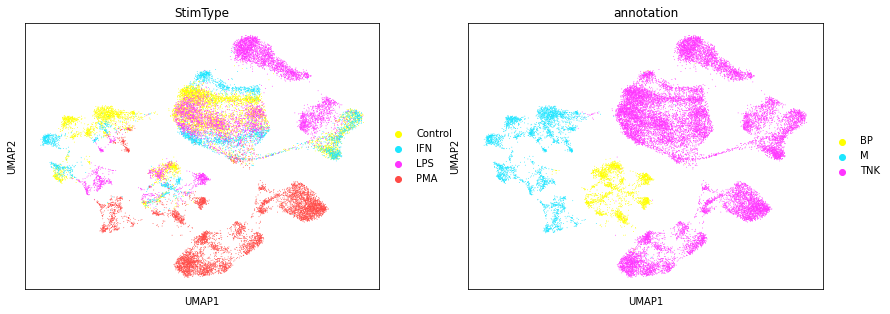

In [23]:
sc.pl.umap(adata, color = ['StimType','annotation'], s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,palette=color_map_clusters_nogrey,
          save='Kartha_stimulation_tsne.svg')

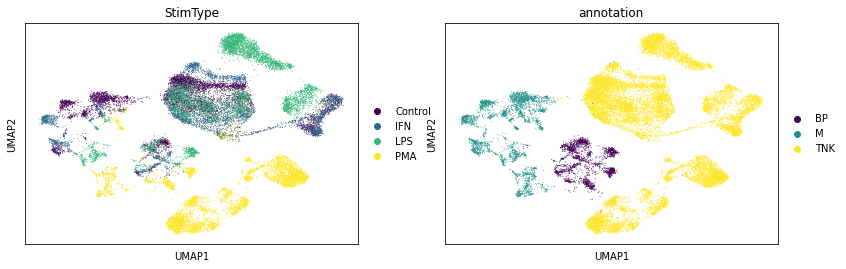

In [24]:
sc.pl.umap(adata, color = ['StimType','annotation'], s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,palette='viridis',
          save='Kartha_stimulation_celltypes_umap_viridis.svg')

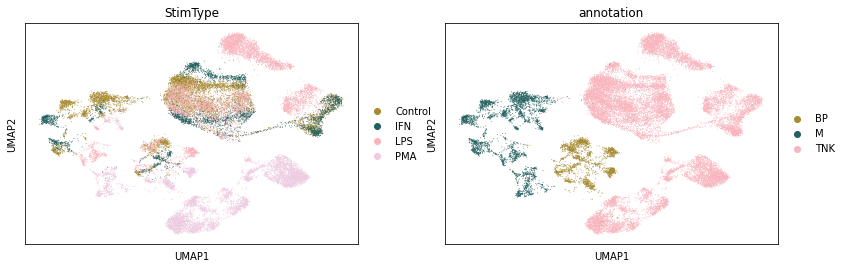

In [25]:
sc.pl.umap(adata, color = ['StimType','annotation'], s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,palette=batlow_20,
          save='Kartha_stimulation_celltypes_umap_batlow.svg')

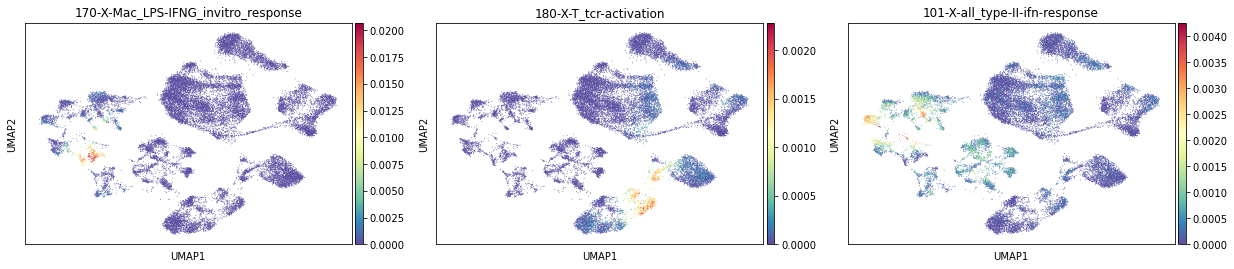

In [26]:
sc.pl.umap(adata, color = factors_of_interest, s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,
          save='Kartha_stimulation_tsne.svg')

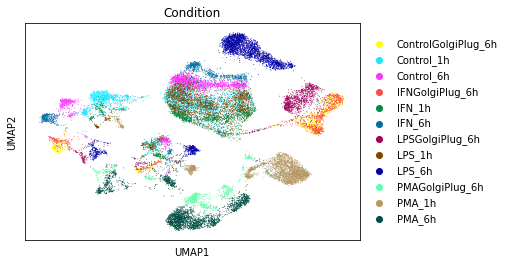

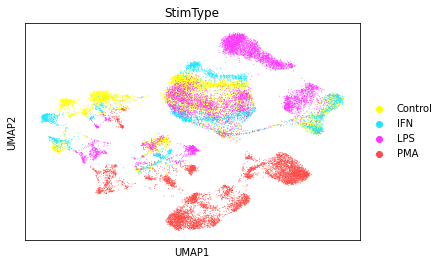

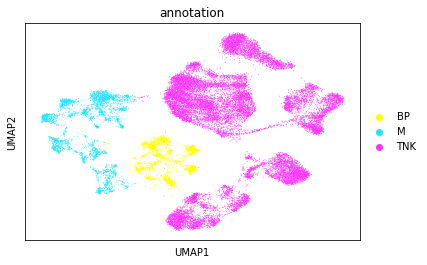

In [27]:
sc.pl.umap(adata, color = ['Condition'], s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,palette=color_map_clusters_nogrey,
          save='Kartha_stimulation_tsne.svg')
sc.pl.umap(adata, color = ['StimType'], s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,palette=color_map_clusters_nogrey,
          save='Kartha_stimulation_tsne.svg')
sc.pl.umap(adata, color = ['annotation'], s = 3, cmap='Spectral_r', legend_fontsize = 10, vmin=0,palette=color_map_clusters_nogrey,
          save='Kartha_stimulation_tsne.svg')

In [47]:
#subset to the conditions with Golgi Plug <-- only here we can be sure that we are only measuring direct perturbation effects
#and not secondary perturbation effects which result from the release of cytokines etc. upon the primary perturbation
adata_celltype = adata[adata.obs['Condition'].isin(['ControlGolgiPlug_6h','IFNGolgiPlug_6h','LPSGolgiPlug_6h','PMAGolgiPlug_6h'])]
adata_celltype

View of AnnData object with n_obs × n_vars = 4486 × 1894
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation', 'study', 'Mac_IL4-IL13_response', 'TNK_cytotoxicity-effectors', 'all_SASP', 'all_RIG-I-like-receptor_signaling', 'B_IL2_response', 'CD4-T_TH17_UP', 'fibro_IL13_response', 'TNK_PD-1_signaling', 'all_pyrimidine_metabolism', 'all_oxidative-phosphorylation', 'all_mTORC1_signaling', 'all_glycerophospholipid_metabolism', 'all_nucleotide_metabolism', 'all_wnt-beta-catenin-signaling', 'all_ARG-PRO_metabolism', 'lung-epi_IL13_response', 'all_n-glycan_degradation', 'NK_IL15_response', 'fibro_IL1B_response', 'all_transmembrane-transport-lysosome', 'all_G2M-tr

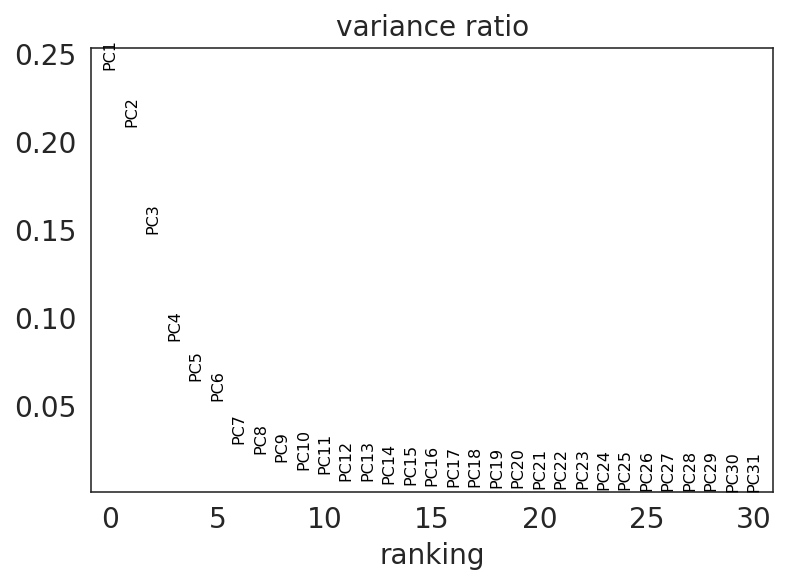

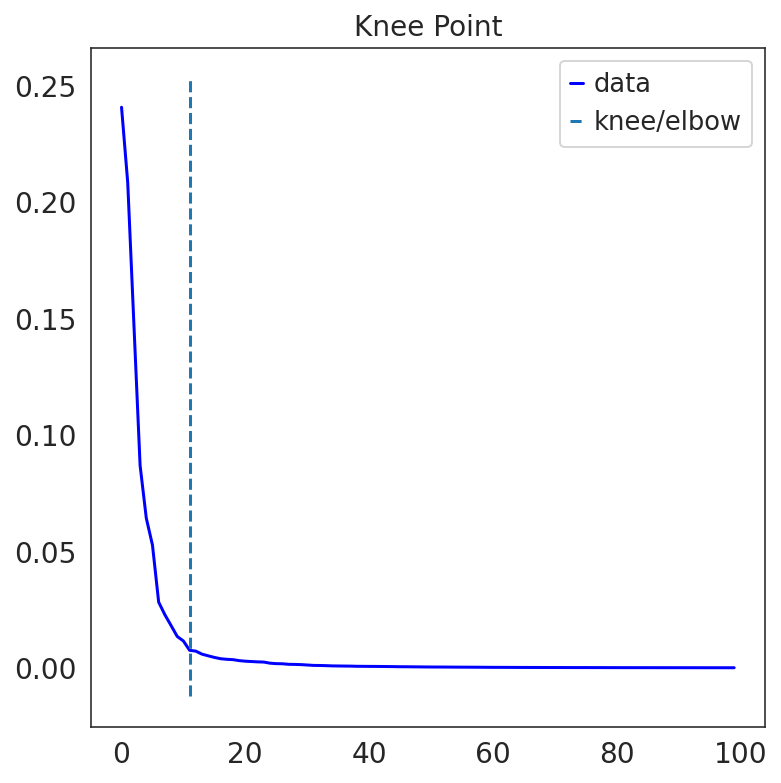

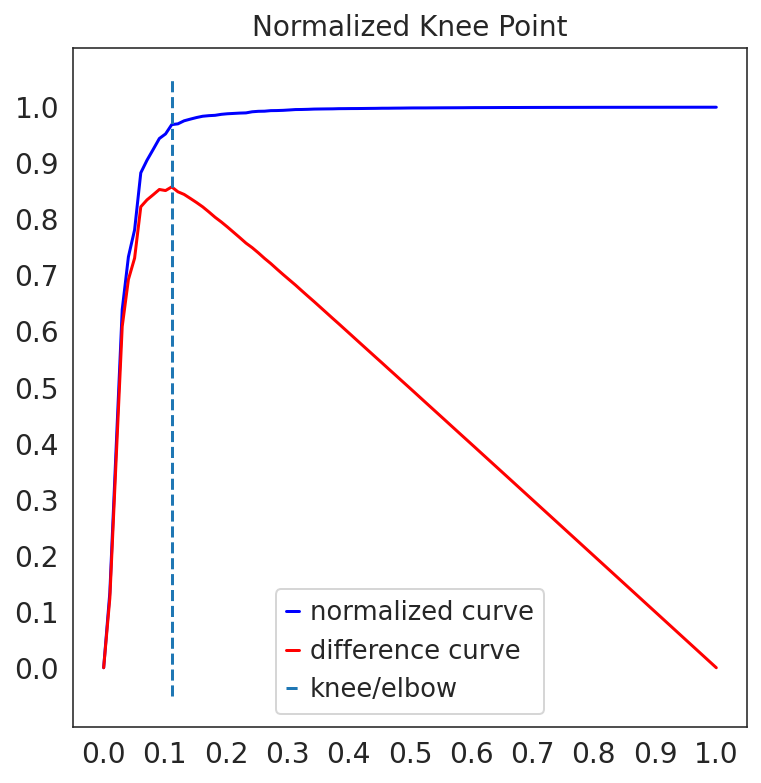

Kneepoint happens at PC: 11
11 PC explain 89.55150106921792 % of variance
setting PCs to 20
variance of 20 is 94.04954328201711 %
number of PCs for clusterings/embeddings is: 20
these explain 94.04954328201711 of variance


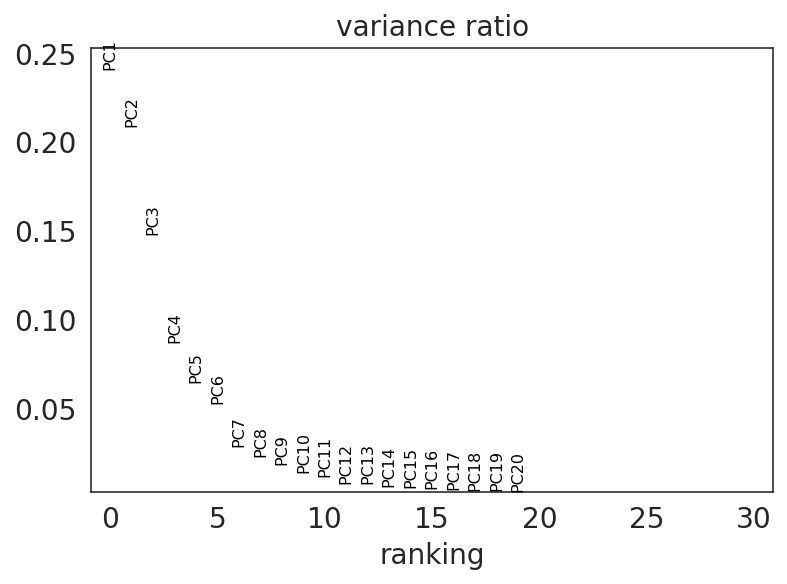

In [48]:
#recalculate embeddings on the subsetted data and neighbors
number_of_PC_used = calculate_optimal_PC(adata_celltype, min_PC = 20, min_var=25, n_comps=100, use_hv=None)
sc.pp.neighbors(adata_celltype, n_neighbors=15, method= 'umap',  n_pcs=number_of_PC_used,
                random_state=0)

In [49]:
#recalc umap
sc.tl.umap(adata_celltype,random_state=0)

In [50]:
adata_celltype = randomize_cells(adata_celltype)

/home/wallet/miniconda3/envs/2022_Peer_SPADE_cellrank2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/wallet/miniconda3/envs/2022_Peer_SPADE_cellrank2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/wallet/miniconda3/envs/2022_Peer_SPADE_cellrank2/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


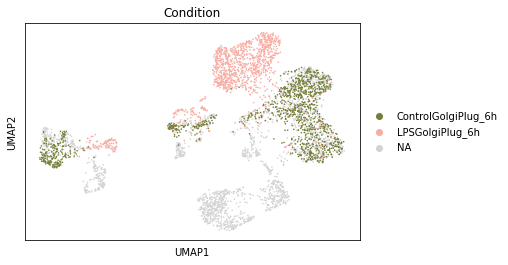

In [32]:
sc.pl.umap(adata_celltype, color = ['Condition'],groups=['ControlGolgiPlug_6h','LPSGolgiPlug_6h'], s = 10, 
           legend_fontsize = 10, vmin=0,palette=batlow_20[4:],
          save='LPSGolgiPlug_6h.svg')

/home/wallet/miniconda3/envs/2022_Peer_SPADE_cellrank2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/wallet/miniconda3/envs/2022_Peer_SPADE_cellrank2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


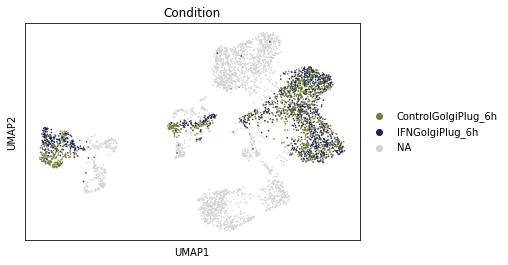

In [33]:
sc.pl.umap(adata_celltype, color = ['Condition'],groups=['ControlGolgiPlug_6h','IFNGolgiPlug_6h'], s = 10, 
           legend_fontsize = 10, vmin=0,palette=batlow_20[4:],
          save='IFNGolgiPlug_6h.svg')

/home/wallet/miniconda3/envs/2022_Peer_SPADE_cellrank2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/wallet/miniconda3/envs/2022_Peer_SPADE_cellrank2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


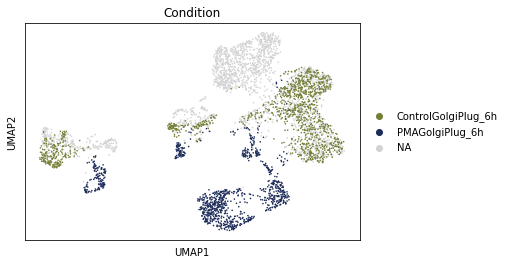

In [34]:
sc.pl.umap(adata_celltype, color = ['Condition'],groups=['ControlGolgiPlug_6h','PMAGolgiPlug_6h'], s = 10, 
           legend_fontsize = 10, vmin=0,palette=batlow_20[4:],
          save='PMAGolgiPlug_6h.svg')

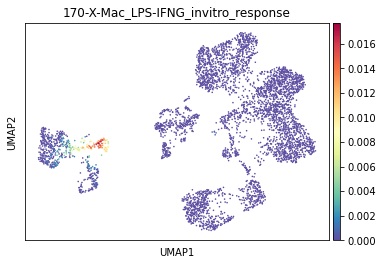

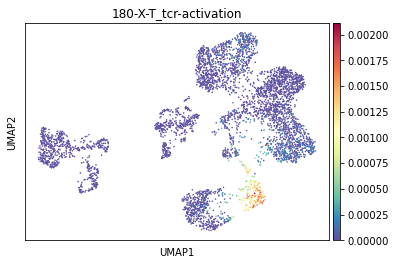

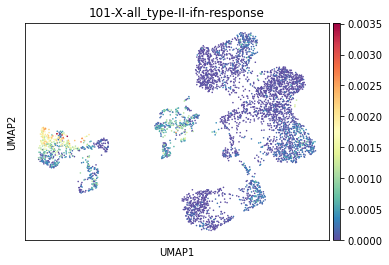

In [35]:
sc.pl.umap(adata_celltype, color = factors_of_interest[0], s = 10, cmap='Spectral_r', legend_fontsize = 10, vmin=0,
          save='Kartha_LPSstimulation_umap.svg')
sc.pl.umap(adata_celltype, color = factors_of_interest[1], s = 10, cmap='Spectral_r', legend_fontsize = 10, vmin=0,
          save='Kartha_TCRstimulation_umap.svg')
sc.pl.umap(adata_celltype, color = factors_of_interest[2], s = 10, cmap='Spectral_r', legend_fontsize = 10, vmin=0,
          save='Kartha_IFNGstimulation_umap.svg')


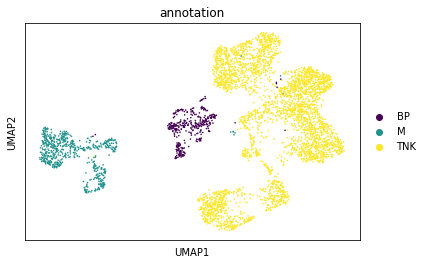

In [36]:
sc.pl.umap(adata_celltype, color = ['annotation'],s = 10, 
           legend_fontsize = 10, vmin=0,palette='viridis',
          save='annotation.svg')

In [37]:
#combine Donor and perturbation annotation to later aggregate the data per donor and condition
adata_celltype.obs['batch'] = adata_celltype.obs['Condition'].str.cat(adata_celltype.obs['Donor'],sep='_')
adata_celltype.obs['batch']

cellBarcode
ControlGolgiPlug_6h_Donor1_gtgtccatccagttcgtagcc    ControlGolgiPlug_6h_Donor1
PMAGolgiPlug_6h_Donor3_tcggcgttcaagaccaggcgg            PMAGolgiPlug_6h_Donor3
PMAGolgiPlug_6h_Donor1_tttggtcgatcacctccgctc            PMAGolgiPlug_6h_Donor1
LPSGolgiPlug_6h_Donor1_cctccttcttaccggcctcgt            LPSGolgiPlug_6h_Donor1
ControlGolgiPlug_6h_Donor2_aaccacatcaagaccatctta    ControlGolgiPlug_6h_Donor2
                                                               ...            
IFNGolgiPlug_6h_Donor2_cttcatcctattcgtcttgta            IFNGolgiPlug_6h_Donor2
LPSGolgiPlug_6h_Donor3_ctaagaagcacagcttaagcg            LPSGolgiPlug_6h_Donor3
PMAGolgiPlug_6h_Donor2_tccgctcgcgactcattcgtt            PMAGolgiPlug_6h_Donor2
LPSGolgiPlug_6h_Donor2_gtggcgcttgaggcaagtgcg            LPSGolgiPlug_6h_Donor2
LPSGolgiPlug_6h_Donor1_tttggtcacagcttcgcaatc            LPSGolgiPlug_6h_Donor1
Name: batch, Length: 4486, dtype: object

In [38]:
set(adata_celltype.obs['annotation'])

{'BP', 'M', 'TNK'}

In [39]:
set(adata_celltype.obs['Condition'])

{'ControlGolgiPlug_6h',
 'IFNGolgiPlug_6h',
 'LPSGolgiPlug_6h',
 'PMAGolgiPlug_6h'}

In [40]:
#mean factor cell score per donor and condition
plot_df_list = []

for i in set(adata_celltype.obs['annotation']):
    adata_celltype_sub = adata_celltype[adata_celltype.obs['annotation']==i]
    plot_df_list.append(aggregate_cell_scores(adata_celltype_sub,'Condition','annotation',factors_of_interest,'batch','Donor',
                            ['Condition','annotation','Donor'],
                            zero_cutoff =0.00))
plot_df_list

[                            170-X-Mac_LPS-IFNG_invitro_response  \
 PMAGolgiPlug_6h_Donor3                                      NaN   
 LPSGolgiPlug_6h_Donor2                                      NaN   
 LPSGolgiPlug_6h_Donor3                                      NaN   
 PMAGolgiPlug_6h_Donor1                                      NaN   
 IFNGolgiPlug_6h_Donor3                                      NaN   
 ControlGolgiPlug_6h_Donor1                                  NaN   
 LPSGolgiPlug_6h_Donor1                                      NaN   
 IFNGolgiPlug_6h_Donor1                                      NaN   
 IFNGolgiPlug_6h_Donor2                                      NaN   
 ControlGolgiPlug_6h_Donor2                                  NaN   
 ControlGolgiPlug_6h_Donor3                                  NaN   
 PMAGolgiPlug_6h_Donor2                                      NaN   
 
                                       Condition annotation   Donor  \
 PMAGolgiPlug_6h_Donor3          PMAGolgiPl

In [41]:
#mean factor expression per donor and perturbation
plot_df = pd.concat(plot_df_list).fillna(0)
plot_df

,170-X-Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,180-X-T_tcr-activation,101-X-all_type-II-ifn-response
PMAGolgiPlug_6h_Donor3,0.000000,PMAGolgiPlug_6h,BP,Donor3,0.000000,0.000193
LPSGolgiPlug_6h_Donor2,0.000000,LPSGolgiPlug_6h,BP,Donor2,0.000000,0.000458
LPSGolgiPlug_6h_Donor3,0.000000,LPSGolgiPlug_6h,BP,Donor3,0.000000,0.000301
PMAGolgiPlug_6h_Donor1,0.000000,PMAGolgiPlug_6h,BP,Donor1,0.000000,0.000471
IFNGolgiPlug_6h_Donor3,0.000000,IFNGolgiPlug_6h,BP,Donor3,0.000000,0.000396
ControlGolgiPlug_6h_Donor1,0.000000,ControlGolgiPlug_6h,BP,Donor1,0.000000,0.000329
LPSGolgiPlug_6h_Donor1,0.000000,LPSGolgiPlug_6h,BP,Donor1,0.000000,0.000445
IFNGolgiPlug_6h_Donor1,0.000000,IFNGolgiPlug_6h,BP,Donor1,0.000000,0.000227
IFNGolgiPlug_6h_Donor2,0.000000,IFNGolgiPlug_6h,BP,Donor2,0.000000,0.000619
ControlGolgiPlug_6h_Donor2,0.000000,ControlGolgiPlug_6h,BP,Donor2,0.000000,0.000480


In [42]:
#subset for LPS stimualted conditions
plot_df_LPS = plot_df[plot_df['Condition'].isin(['LPSGolgiPlug_6h','ControlGolgiPlug_6h'])]
plot_df_LPS

,170-X-Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,180-X-T_tcr-activation,101-X-all_type-II-ifn-response
LPSGolgiPlug_6h_Donor2,0.000000,LPSGolgiPlug_6h,BP,Donor2,0.000000,0.000458
LPSGolgiPlug_6h_Donor3,0.000000,LPSGolgiPlug_6h,BP,Donor3,0.000000,0.000301
ControlGolgiPlug_6h_Donor1,0.000000,ControlGolgiPlug_6h,BP,Donor1,0.000000,0.000329
LPSGolgiPlug_6h_Donor1,0.000000,LPSGolgiPlug_6h,BP,Donor1,0.000000,0.000445
ControlGolgiPlug_6h_Donor2,0.000000,ControlGolgiPlug_6h,BP,Donor2,0.000000,0.000480
ControlGolgiPlug_6h_Donor3,0.000000,ControlGolgiPlug_6h,BP,Donor3,0.000000,0.000379
LPSGolgiPlug_6h_Donor2,0.000000,LPSGolgiPlug_6h,TNK,Donor2,0.000027,0.000064
LPSGolgiPlug_6h_Donor3,0.000000,LPSGolgiPlug_6h,TNK,Donor3,0.000023,0.000068
ControlGolgiPlug_6h_Donor1,0.000000,ControlGolgiPlug_6h,TNK,Donor1,0.000020,0.000040
LPSGolgiPlug_6h_Donor1,0.000000,LPSGolgiPlug_6h,TNK,Donor1,0.000026,0.000040


Kartha_celltype_LPS_boxplot170-X-Mac_LPS-IFNG_invitro_response.svg


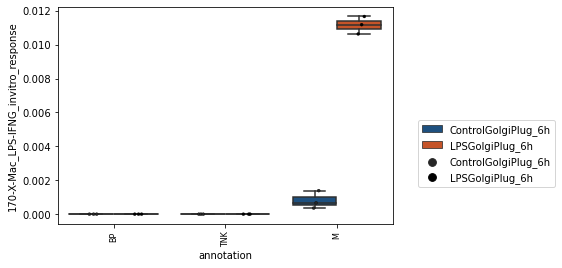

In [43]:
#plot LPS
factor='170-X-Mac_LPS-IFNG_invitro_response'
save_name ='Kartha_celltype_LPS_boxplot'+factor+'.svg'
hue_order = ['ControlGolgiPlug_6h','LPSGolgiPlug_6h']
sns.boxplot(data=plot_df_LPS,x='annotation', 
                y=factor, hue='Condition', order=None, hue_order=hue_order, 
                orient=None, color=None, palette=blue_red, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=plot_df_LPS,x='annotation', 
                y=factor, hue='Condition', order=None, hue_order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.xlim(-25,100)
plt.legend(bbox_to_anchor=[1.5, 0.5])
plt.xticks(rotation=90,size=8)
plt.savefig(fig_save_path+save_name)
plot_df.to_csv(fig_save_path + 'source_data/'+ save_name[:-4]+'.csv')
print(save_name)

In [46]:
plot_df_LPS_subset[plot_df_LPS_subset['Condition']=='ControlGolgiPlug_6h']

,170-X-Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,180-X-T_tcr-activation,101-X-all_type-II-ifn-response
ControlGolgiPlug_6h_Donor3,0.000000,ControlGolgiPlug_6h,BP,Donor3,0.000000,0.000379
ControlGolgiPlug_6h_Donor3,0.000000,ControlGolgiPlug_6h,TNK,Donor3,0.000021,0.000049
ControlGolgiPlug_6h_Donor3,0.001388,ControlGolgiPlug_6h,M,Donor3,0.000000,0.000399


In [59]:
fold_changes = []
for i in set(plot_df_LPS['annotation']):
    plot_df_LPS_subset = plot_df_LPS[plot_df_LPS['annotation']==i]
    fold_changes_cell = []
    for j in set(plot_df_LPS_subset['Donor']):
        plot_df_LPS_subset_celltype = plot_df_LPS_subset[plot_df_LPS_subset['Donor']==j]
        b = list(plot_df_LPS_subset_celltype[plot_df_LPS_subset_celltype['Condition']=='ControlGolgiPlug_6h']['170-X-Mac_LPS-IFNG_invitro_response'])[0]
        a = list(plot_df_LPS_subset_celltype[plot_df_LPS_subset_celltype['Condition']!='ControlGolgiPlug_6h']['170-X-Mac_LPS-IFNG_invitro_response'])[0]
        if a!=0 and b!=0:
            fold_changes_cell.append(a/b)
        elif a==0 and b==0:
            print('for',i,j,'both values are 0')
        else:
            print('check your data')
    fold_changes.append(fold_changes_cell)

for BP Donor3 both values are 0
for BP Donor1 both values are 0
for BP Donor2 both values are 0
for TNK Donor3 both values are 0
for TNK Donor1 both values are 0
for TNK Donor2 both values are 0


In [60]:
np.mean(fold_changes[-1])

18.763068355492777

In [70]:
plot_df_IFN = plot_df[plot_df['Condition'].isin(['IFNGolgiPlug_6h','ControlGolgiPlug_6h'])]
plot_df_IFN

,170-X-Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,180-X-T_tcr-activation,101-X-all_type-II-ifn-response
IFNGolgiPlug_6h_Donor3,0.000000,IFNGolgiPlug_6h,BP,Donor3,0.000000,0.000396
ControlGolgiPlug_6h_Donor1,0.000000,ControlGolgiPlug_6h,BP,Donor1,0.000000,0.000329
IFNGolgiPlug_6h_Donor1,0.000000,IFNGolgiPlug_6h,BP,Donor1,0.000000,0.000227
IFNGolgiPlug_6h_Donor2,0.000000,IFNGolgiPlug_6h,BP,Donor2,0.000000,0.000619
ControlGolgiPlug_6h_Donor2,0.000000,ControlGolgiPlug_6h,BP,Donor2,0.000000,0.000480
ControlGolgiPlug_6h_Donor3,0.000000,ControlGolgiPlug_6h,BP,Donor3,0.000000,0.000379
IFNGolgiPlug_6h_Donor3,0.000000,IFNGolgiPlug_6h,TNK,Donor3,0.000031,0.000083
ControlGolgiPlug_6h_Donor1,0.000000,ControlGolgiPlug_6h,TNK,Donor1,0.000020,0.000040
IFNGolgiPlug_6h_Donor2,0.000000,IFNGolgiPlug_6h,TNK,Donor2,0.000022,0.000064
IFNGolgiPlug_6h_Donor1,0.000000,IFNGolgiPlug_6h,TNK,Donor1,0.000034,0.000078


Kartha_celltype_IFN_boxplot101-X-all_type-II-ifn-response.svg


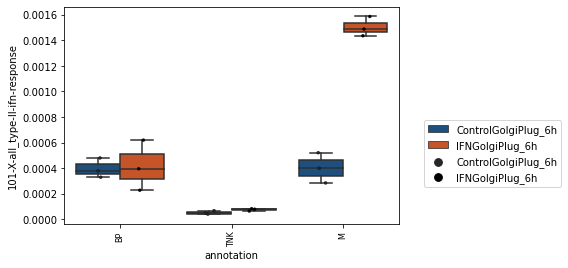

In [71]:
#plot
factor='101-X-all_type-II-ifn-response'
save_name ='Kartha_celltype_IFN_boxplot'+factor+'.svg'
hue_order = ['ControlGolgiPlug_6h','IFNGolgiPlug_6h']
sns.boxplot(data=plot_df_IFN,x='annotation', 
                y=factor, hue='Condition', order=None, hue_order=hue_order, 
                orient=None, color=None, palette=blue_red, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=plot_df_IFN,x='annotation', 
                y=factor, hue='Condition', order=None, hue_order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.xlim(-25,100)
plt.legend(bbox_to_anchor=[1.5, 0.5])
plt.xticks(rotation=90,size=8)
plt.savefig(fig_save_path+save_name)
plot_df.to_csv(fig_save_path + 'source_data/'+ save_name[:-4]+'.csv')
print(save_name)

In [85]:
fold_changes = []
order = []
for i in set(plot_df_IFN['annotation']):
    order.append(i)
    plot_df_IFN_subset = plot_df_IFN[plot_df_IFN['annotation']==i]
    fold_changes_cell = []
    for j in set(plot_df_IFN_subset['Donor']):
        plot_df_IFN_subset_celltype = plot_df_IFN_subset[plot_df_IFN_subset['Donor']==j]
        b = list(plot_df_IFN_subset_celltype[plot_df_IFN_subset_celltype['Condition']=='ControlGolgiPlug_6h']['101-X-all_type-II-ifn-response'])[0]
        a = list(plot_df_IFN_subset_celltype[plot_df_IFN_subset_celltype['Condition']!='ControlGolgiPlug_6h']['101-X-all_type-II-ifn-response'])[0]
        if a!=0 and b!=0:
            fold_changes_cell.append(a/b)
        elif a==0 and b==0:
            print('for',i,j,'both values are 0')
        else:
            print('check your data')
    fold_changes.append(fold_changes_cell)

In [62]:
#subset TCR stimualted samples
plot_df_TCR = plot_df[plot_df['Condition'].isin(['PMAGolgiPlug_6h','ControlGolgiPlug_6h'])]
plot_df_TCR

,170-X-Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,180-X-T_tcr-activation,101-X-all_type-II-ifn-response
PMAGolgiPlug_6h_Donor3,0.000000,PMAGolgiPlug_6h,BP,Donor3,0.000000,0.000193
PMAGolgiPlug_6h_Donor1,0.000000,PMAGolgiPlug_6h,BP,Donor1,0.000000,0.000471
ControlGolgiPlug_6h_Donor1,0.000000,ControlGolgiPlug_6h,BP,Donor1,0.000000,0.000329
ControlGolgiPlug_6h_Donor2,0.000000,ControlGolgiPlug_6h,BP,Donor2,0.000000,0.000480
ControlGolgiPlug_6h_Donor3,0.000000,ControlGolgiPlug_6h,BP,Donor3,0.000000,0.000379
PMAGolgiPlug_6h_Donor2,0.000000,PMAGolgiPlug_6h,BP,Donor2,0.000000,0.000411
PMAGolgiPlug_6h_Donor3,0.000000,PMAGolgiPlug_6h,TNK,Donor3,0.000264,0.000074
PMAGolgiPlug_6h_Donor1,0.000000,PMAGolgiPlug_6h,TNK,Donor1,0.000208,0.000049
ControlGolgiPlug_6h_Donor1,0.000000,ControlGolgiPlug_6h,TNK,Donor1,0.000020,0.000040
ControlGolgiPlug_6h_Donor2,0.000000,ControlGolgiPlug_6h,TNK,Donor2,0.000027,0.000068


/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#000000'` for same effect.
  warnings.warn(msg, FutureWarning)


Kartha_celltype_TCR_boxplot180-X-T_tcr-activation.svg


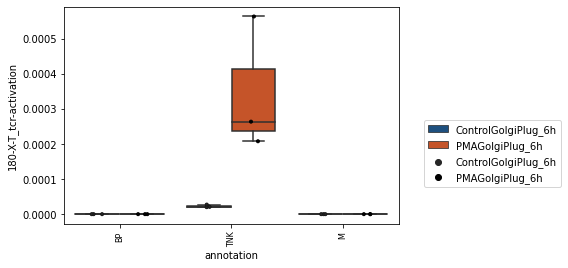

In [47]:
#plot TCR
factor='180-X-T_tcr-activation'
save_name ='Kartha_celltype_TCR_boxplot'+factor+'.svg'
hue_order = ['ControlGolgiPlug_6h','PMAGolgiPlug_6h']
sns.boxplot(data=plot_df_TCR,x='annotation', 
                y=factor, hue='Condition', order=None, hue_order=hue_order, 
                orient=None, color=None, palette=blue_red, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=plot_df_TCR,x='annotation', 
                y=factor, hue='Condition', order=None, hue_order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.xlim(-25,100)
plt.legend(bbox_to_anchor=[1.5, 0.5])
plt.xticks(rotation=90,size=8)
plt.savefig(fig_save_path+save_name)
plot_df.to_csv(fig_save_path + 'source_data/'+ save_name[:-4]+'.csv')
print(save_name)

In [66]:
fold_changes = []
for i in set(plot_df_TCR['annotation']):
    plot_df_TCR_subset = plot_df_TCR[plot_df_TCR['annotation']==i]
    fold_changes_cell = []
    for j in set(plot_df_TCR_subset['Donor']):
        plot_df_TCR_subset_celltype = plot_df_TCR_subset[plot_df_TCR_subset['Donor']==j]
        b = list(plot_df_TCR_subset_celltype[plot_df_TCR_subset_celltype['Condition']=='ControlGolgiPlug_6h']['180-X-T_tcr-activation'])[0]
        a = list(plot_df_TCR_subset_celltype[plot_df_TCR_subset_celltype['Condition']!='ControlGolgiPlug_6h']['180-X-T_tcr-activation'])[0]
        if a!=0 and b!=0:
            fold_changes_cell.append(a/b)
        elif a==0 and b==0:
            print('for',i,j,'both values are 0')
        else:
            print('check your data')
    fold_changes.append(fold_changes_cell)

for BP Donor3 both values are 0
for BP Donor1 both values are 0
for BP Donor2 both values are 0
for M Donor3 both values are 0
for M Donor1 both values are 0
for M Donor2 both values are 0


# expimap

In [10]:
#data_paths
adata_path = DATA_DIR + 'PBMC-X-NA-X-Kartha-X-scRNAseq-X-10.1016_j.xgen.2022.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito_alpha07_2khv_nonewnodes_new.h5ad'
model_path = DATA_DIR + 'PBMC-X-NA-X-Kartha-X-scRNAseq-X-10.1016_j.xgen.2022.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito_alpha07_2khv_nonewnodes_new.pickle'

input_gene_sets = working_dir +'SPADE_genes_x_genesets.csv'


In [11]:
input_df = pd.read_csv(input_gene_sets)
input_df

,gs.name,g.name
0,all_multidrug-resistance,ABCC4
1,all_multidrug-resistance,ABCB4
2,all_multidrug-resistance,ABCC3
3,all_multidrug-resistance,ABCC1
4,all_porphyrine-heme_metabolism,UROS
...,...,...
7855,all_folate_metabolism,SLC19A1
7856,all_folate_metabolism,AMT
7857,all_folate_metabolism,FOLR3
7858,all_folate_metabolism,FTCD


In [12]:
adata = sc.read(adata_path)
adata

Only considering the two last: ['.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito_alpha07_2khv_nonewnodes_new', '.h5ad'].
Only considering the two last: ['.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito_alpha07_2khv_nonewnodes_new', '.h5ad'].


AnnData object with n_obs × n_vars = 23754 × 1894
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation', 'study'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm', 'highly_variable_intersection'
    uns: 'Condition_colors', 'Donor_colors', 'annotation_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'pheno_var_k40_colors', 'terms', 'tsne', 'umap'
    obsm: 'X_cvae', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'I', 'PCs'
    layers: 'imputed', 'raw'
    obsp: 'connectivities', 'distances'

In [13]:
import pickle
with open(model_path, 'rb') as f:
    q_intr_cvae = pickle.load(f)

 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [14]:
q_intr_cvae.latent_directions(adata=adata)

In [15]:
adata.uns['terms']

array(['Mac_IL4-IL13_response', 'TNK_cytotoxicity-effectors', 'all_SASP',
       'all_RIG-I-like-receptor_signaling', 'B_IL2_response',
       'CD4-T_TH17_UP', 'fibro_IL13_response', 'TNK_PD-1_signaling',
       'all_pyrimidine_metabolism', 'all_oxidative-phosphorylation',
       'all_mTORC1_signaling', 'all_glycerophospholipid_metabolism',
       'all_nucleotide_metabolism', 'all_wnt-beta-catenin-signaling',
       'all_ARG-PRO_metabolism', 'lung-epi_IL13_response',
       'all_n-glycan_degradation', 'NK_IL15_response',
       'fibro_IL1B_response', 'all_transmembrane-transport-lysosome',
       'all_G2M-transition', 'all_IL6-JAK-STAT3_signaling',
       'all_JAK-STAT_signaling', 'all_TLR_signaling',
       'leuko_transendothelial-migration',
       'lung-smooth-muscle_TGFB1_response', 'all_GPI-anchor_synthesis',
       'all_cyclic-nucleotide_metabolism', 'all_citric-acid-cycle',
       'all_macroautophagy', 'M_mac_CSF1_response', 'all_ros_response',
       'all_TYR_metabolism', 'DC_L

In [16]:
gene_ls_ls = []
for i in list(adata.uns['terms']):
    gene_list =list(q_intr_cvae.term_genes(i, terms=adata.uns['terms'])['genes'][0:100])
    if len(q_intr_cvae.term_genes(i, terms=adata.uns['terms']))<100:
        add_number = 100-len(q_intr_cvae.term_genes(i, terms=adata.uns['terms']))
        gene_list = gene_list+ add_number*[np.nan]
    gene_ls_ls.append(gene_list)

np.array(gene_ls_ls).shape

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['in_mask'][in_mask] = True
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['in_mask'][in_mask] = True
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['in_mask'][in_mask] = True
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['in_mask'][in_mask] = True
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['in_mask'][in_mask] = True
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['in_mask'][in_mask] = True
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

(109, 100)

In [17]:
import cytopus
G = cytopus.kb.KnowledgeBase()

KnowledgeBase object containing 75 cell types and 201 cellular processes



In [21]:
overlap_df = cp.tl.label_marker_genes(np.array(gene_ls_ls), G.processes, threshold = 0.2)
overlap_df

,lung-epi_IL4_response,all_carnitine-shuttle,fibro_IGF1_response,p-DC_CpG-TLR9_response,all_autophagy_regulation_positive,B_IL2_response,all_SASP,all_fatty-acid-beta-oxidation-mitochondrial,all_PI3K-AKT-mTOR_signaling,all_eicosanoid_metabolism,...,all_amino-sugar-nucleotide-sugar_metabolism,all_GLU_metabolism,all_pentose-phosphate-pathway,all_galactose_metabolism,all_Beta-Ala_metabolism,DC_CD40L_response,Mac_LPS_response,all_autophagy-chaperone-mediated,all_nucleotide_metabolism,all_CYS_metabolism
all_transmembrane-transport-ER,0.030000,0.0,0.020000,0.000000,0.040000,0.052632,0.014925,0.0,0.010000,0.000000,...,0.00,0.000000,0.0,0.0,0.0,0.047619,0.013514,0.0625,0.000000,0.00
TNK_cytotoxicity-effectors,0.040000,0.0,0.010000,0.285714,0.020000,0.210526,0.000000,0.0,0.030000,0.026316,...,0.00,0.000000,0.0,0.0,0.0,0.059524,0.000000,0.0000,0.000000,0.00
all_SASP,0.020000,0.0,0.030000,0.142857,0.020000,0.105263,0.507463,0.0,0.030000,0.000000,...,0.00,0.024390,0.0,0.0,0.0,0.059524,0.000000,0.0000,0.000000,0.00
all_type-I-ifn-response,0.010000,0.0,0.030000,0.142857,0.050000,0.052632,0.014925,0.0,0.030000,0.000000,...,0.00,0.000000,0.0,0.0,0.0,0.035714,0.027027,0.0625,0.038462,0.00
B_IL2_response,0.030000,0.0,0.030000,0.000000,0.040000,0.421053,0.029851,0.0,0.000000,0.000000,...,0.00,0.024390,0.0,0.0,0.0,0.035714,0.013514,0.0625,0.000000,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mac_LPS-IFNG_invitro_response,0.010000,0.0,0.050000,0.142857,0.020000,0.052632,0.029851,0.0,0.030000,0.000000,...,0.05,0.000000,0.0,0.0,0.0,0.035714,0.000000,0.0625,0.000000,0.00
all_ascorbate-uptake,0.020000,0.0,0.020000,0.142857,0.030000,0.052632,0.029851,0.0,0.020000,0.000000,...,0.00,0.170732,0.0,0.0,0.0,0.035714,0.000000,0.0625,0.000000,0.10
all_transmembrane-transport-ER,0.010000,0.0,0.030000,0.142857,0.030000,0.052632,0.000000,0.0,0.040000,0.052632,...,0.00,0.024390,0.0,0.0,0.0,0.023810,0.000000,0.0625,0.000000,0.00
all_peroxisome-component,0.010000,0.0,0.030000,0.142857,0.000000,0.052632,0.014925,0.0,0.030000,0.000000,...,0.00,0.000000,0.0,0.0,0.0,0.011905,0.000000,0.0625,0.000000,0.00


In [22]:
adata.uns['terms']

array(['Mac_IL4-IL13_response', 'TNK_cytotoxicity-effectors', 'all_SASP',
       'all_RIG-I-like-receptor_signaling', 'B_IL2_response',
       'CD4-T_TH17_UP', 'fibro_IL13_response', 'TNK_PD-1_signaling',
       'all_pyrimidine_metabolism', 'all_oxidative-phosphorylation',
       'all_mTORC1_signaling', 'all_glycerophospholipid_metabolism',
       'all_nucleotide_metabolism', 'all_wnt-beta-catenin-signaling',
       'all_ARG-PRO_metabolism', 'lung-epi_IL13_response',
       'all_n-glycan_degradation', 'NK_IL15_response',
       'fibro_IL1B_response', 'all_transmembrane-transport-lysosome',
       'all_G2M-transition', 'all_IL6-JAK-STAT3_signaling',
       'all_JAK-STAT_signaling', 'all_TLR_signaling',
       'leuko_transendothelial-migration',
       'lung-smooth-muscle_TGFB1_response', 'all_GPI-anchor_synthesis',
       'all_cyclic-nucleotide_metabolism', 'all_citric-acid-cycle',
       'all_macroautophagy', 'M_mac_CSF1_response', 'all_ros_response',
       'all_TYR_metabolism', 'DC_L

In [23]:
#get factor names provided by expimap
overlap_df.index = adata.uns['terms']

In [24]:
#add latents to obs
terms = adata.uns['terms']
select_terms = list(adata.uns['terms'])
idx = []

for j in select_terms:
    for i,v in enumerate(terms):
        if v == j:
            idx.append(i)
            
            
            
latents = (q_intr_cvae.get_latent(adata.X, adata.obs['study'], mean=False) * adata.uns['directions'])[:, idx]


for i,v in enumerate(select_terms):
           adata.obs[v] = latents[:, i]

/scratch/lsftmp/17667690.tmpdir/ipykernel_465130/3187254465.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = latents[:, i]
/scratch/lsftmp/17667690.tmpdir/ipykernel_465130/3187254465.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[v] = latents[:, i]
/scratch/lsftmp/17667690.tmpdir/ipykernel_465130/3187254465.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

In [25]:
adata

AnnData object with n_obs × n_vars = 23754 × 1894
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation', 'study', 'Mac_IL4-IL13_response', 'TNK_cytotoxicity-effectors', 'all_SASP', 'all_RIG-I-like-receptor_signaling', 'B_IL2_response', 'CD4-T_TH17_UP', 'fibro_IL13_response', 'TNK_PD-1_signaling', 'all_pyrimidine_metabolism', 'all_oxidative-phosphorylation', 'all_mTORC1_signaling', 'all_glycerophospholipid_metabolism', 'all_nucleotide_metabolism', 'all_wnt-beta-catenin-signaling', 'all_ARG-PRO_metabolism', 'lung-epi_IL13_response', 'all_n-glycan_degradation', 'NK_IL15_response', 'fibro_IL1B_response', 'all_transmembrane-transport-lysosome', 'all_G2M-transitio

In [26]:
adata_celltype = adata[adata.obs['Condition'].isin(['ControlGolgiPlug_6h','IFNGolgiPlug_6h','LPSGolgiPlug_6h','PMAGolgiPlug_6h'])]
adata_celltype

View of AnnData object with n_obs × n_vars = 4486 × 1894
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation', 'study', 'Mac_IL4-IL13_response', 'TNK_cytotoxicity-effectors', 'all_SASP', 'all_RIG-I-like-receptor_signaling', 'B_IL2_response', 'CD4-T_TH17_UP', 'fibro_IL13_response', 'TNK_PD-1_signaling', 'all_pyrimidine_metabolism', 'all_oxidative-phosphorylation', 'all_mTORC1_signaling', 'all_glycerophospholipid_metabolism', 'all_nucleotide_metabolism', 'all_wnt-beta-catenin-signaling', 'all_ARG-PRO_metabolism', 'lung-epi_IL13_response', 'all_n-glycan_degradation', 'NK_IL15_response', 'fibro_IL1B_response', 'all_transmembrane-transport-lysosome', 'all_G2M-tr

In [27]:
adata_celltype.obs['batch'] = adata_celltype.obs['Condition'].str.cat(adata_celltype.obs['Donor'],sep='_')
adata_celltype.obs['batch']

/scratch/lsftmp/17667690.tmpdir/ipykernel_465130/3132211419.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_celltype.obs['batch'] = adata_celltype.obs['Condition'].str.cat(adata_celltype.obs['Donor'],sep='_')


cellBarcode
ControlGolgiPlug_6h_Donor1_ttgaggcacgagaaccgaacc    ControlGolgiPlug_6h_Donor1
ControlGolgiPlug_6h_Donor1_catgtatcaggcggacgtatt    ControlGolgiPlug_6h_Donor1
ControlGolgiPlug_6h_Donor1_cgattacattattctagtacc    ControlGolgiPlug_6h_Donor1
ControlGolgiPlug_6h_Donor1_attcgttctgcgcctatactt    ControlGolgiPlug_6h_Donor1
ControlGolgiPlug_6h_Donor1_agtaagcgtaatacaagttat    ControlGolgiPlug_6h_Donor1
                                                               ...            
PMAGolgiPlug_6h_Donor3_aaccacaacacgcgaaccaca            PMAGolgiPlug_6h_Donor3
PMAGolgiPlug_6h_Donor3_gtaatacaactcttacacgcg            PMAGolgiPlug_6h_Donor3
PMAGolgiPlug_6h_Donor3_ggcggaacgacactccaagct            PMAGolgiPlug_6h_Donor3
PMAGolgiPlug_6h_Donor3_acagtacaggacgtccaagct            PMAGolgiPlug_6h_Donor3
PMAGolgiPlug_6h_Donor3_cggtacgataggcaccaagct            PMAGolgiPlug_6h_Donor3
Name: batch, Length: 4486, dtype: object

First we will assess the factors which have been labeled by expiMap as by the input gene sets matching the perturbation

In [28]:
#the first gene set is labeled Mac_IFNG_response response but this is not correct (the gene set has been relabeled) it 
#is the same Mac_LPS-IFNG_invitro_response gene set used in the Spectra model)
factors_of_interest = ['Mac_LPS-IFNG_invitro_response','T_tcr-activation','all_type-II-ifn-response']

In [31]:
#mean exp per donor
plot_df_list = []

for i in set(adata_celltype.obs['annotation']):
    adata_celltype_sub = adata_celltype[adata_celltype.obs['annotation']==i]
    plot_df_list.append(aggregate_cell_scores(adata_celltype_sub,'Condition','annotation',factors_of_interest,'batch','Donor',
                            ['Condition','annotation','Donor'],
                            zero_cutoff =None))#0.00))
plot_df_list

[                            Mac_LPS-IFNG_invitro_response  \
 LPSGolgiPlug_6h_Donor1                          -0.010131   
 ControlGolgiPlug_6h_Donor1                      -0.190435   
 IFNGolgiPlug_6h_Donor1                          -0.177082   
 ControlGolgiPlug_6h_Donor2                      -0.005815   
 PMAGolgiPlug_6h_Donor3                          -0.054350   
 IFNGolgiPlug_6h_Donor3                           0.138891   
 IFNGolgiPlug_6h_Donor2                          -0.005635   
 LPSGolgiPlug_6h_Donor3                          -0.174644   
 PMAGolgiPlug_6h_Donor1                          -0.050337   
 ControlGolgiPlug_6h_Donor3                      -0.011304   
 PMAGolgiPlug_6h_Donor2                          -0.145855   
 LPSGolgiPlug_6h_Donor2                          -0.192594   
 
                                       Condition annotation   Donor  \
 LPSGolgiPlug_6h_Donor1          LPSGolgiPlug_6h         BP  Donor1   
 ControlGolgiPlug_6h_Donor1  ControlGolgiPlug_6h  

In [32]:
plot_df = pd.concat(plot_df_list).fillna(0)
plot_df

,Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,T_tcr-activation,all_type-II-ifn-response
LPSGolgiPlug_6h_Donor1,-0.010131,LPSGolgiPlug_6h,BP,Donor1,-1.060892,0.025842
ControlGolgiPlug_6h_Donor1,-0.190435,ControlGolgiPlug_6h,BP,Donor1,-1.080928,0.144862
IFNGolgiPlug_6h_Donor1,-0.177082,IFNGolgiPlug_6h,BP,Donor1,-0.955056,0.111901
ControlGolgiPlug_6h_Donor2,-0.005815,ControlGolgiPlug_6h,BP,Donor2,-1.071338,0.094773
PMAGolgiPlug_6h_Donor3,-0.054350,PMAGolgiPlug_6h,BP,Donor3,0.067871,-0.142219
IFNGolgiPlug_6h_Donor3,0.138891,IFNGolgiPlug_6h,BP,Donor3,-1.248998,-0.151766
IFNGolgiPlug_6h_Donor2,-0.005635,IFNGolgiPlug_6h,BP,Donor2,-1.121007,-0.008847
LPSGolgiPlug_6h_Donor3,-0.174644,LPSGolgiPlug_6h,BP,Donor3,-1.160152,0.126938
PMAGolgiPlug_6h_Donor1,-0.050337,PMAGolgiPlug_6h,BP,Donor1,0.179429,-0.057284
ControlGolgiPlug_6h_Donor3,-0.011304,ControlGolgiPlug_6h,BP,Donor3,-1.129230,-0.002149


In [33]:
plot_df_LPS = plot_df[plot_df['Condition'].isin(['LPSGolgiPlug_6h','ControlGolgiPlug_6h'])]
plot_df_LPS

,Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,T_tcr-activation,all_type-II-ifn-response
LPSGolgiPlug_6h_Donor1,-0.010131,LPSGolgiPlug_6h,BP,Donor1,-1.060892,0.025842
ControlGolgiPlug_6h_Donor1,-0.190435,ControlGolgiPlug_6h,BP,Donor1,-1.080928,0.144862
ControlGolgiPlug_6h_Donor2,-0.005815,ControlGolgiPlug_6h,BP,Donor2,-1.071338,0.094773
LPSGolgiPlug_6h_Donor3,-0.174644,LPSGolgiPlug_6h,BP,Donor3,-1.160152,0.126938
ControlGolgiPlug_6h_Donor3,-0.011304,ControlGolgiPlug_6h,BP,Donor3,-1.129230,-0.002149
LPSGolgiPlug_6h_Donor2,-0.192594,LPSGolgiPlug_6h,BP,Donor2,-1.076564,0.018449
LPSGolgiPlug_6h_Donor1,0.035565,LPSGolgiPlug_6h,TNK,Donor1,-0.483980,-0.009798
ControlGolgiPlug_6h_Donor1,-0.083379,ControlGolgiPlug_6h,TNK,Donor1,-0.862164,-0.008474
ControlGolgiPlug_6h_Donor2,0.006968,ControlGolgiPlug_6h,TNK,Donor2,-0.737977,0.079110
LPSGolgiPlug_6h_Donor3,0.109570,LPSGolgiPlug_6h,TNK,Donor3,-1.020617,0.097661


/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#000000'` for same effect.
  warnings.warn(msg, FutureWarning)


Kartha_celltype_LPS_boxplot_expimapMac_LPS-IFNG_invitro_responsesoftmask.svg


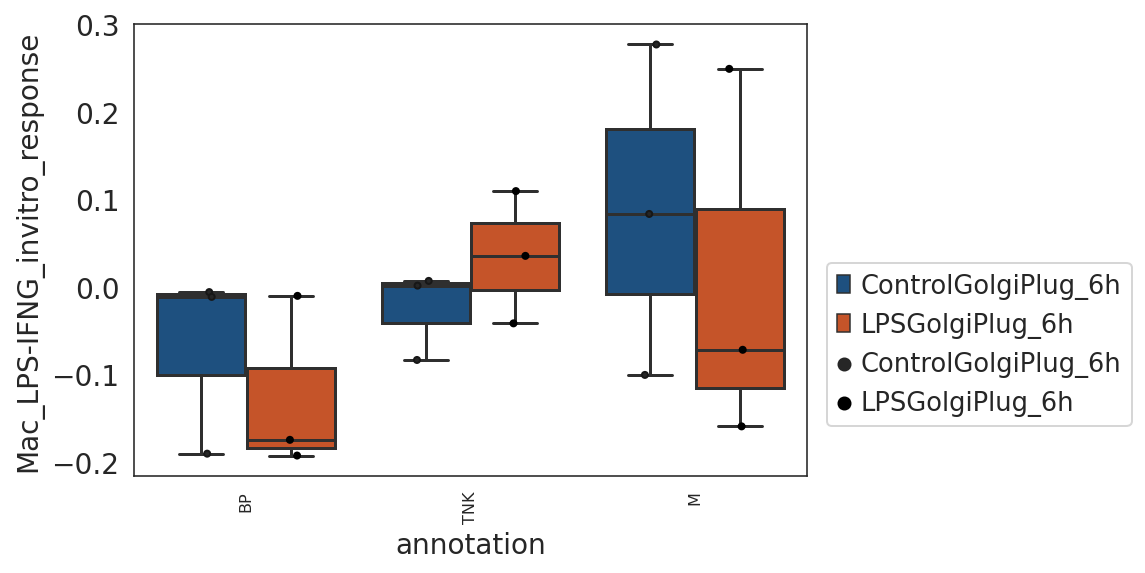

In [35]:
#plot
%matplotlib inline
sns.set_style('white')
factor='Mac_LPS-IFNG_invitro_response' 
save_name ='Kartha_celltype_LPS_boxplot_expimap'+factor+'softmask.svg'
hue_order = ['ControlGolgiPlug_6h','LPSGolgiPlug_6h']
sns.boxplot(data=plot_df_LPS,x='annotation', 
                y=factor, hue='Condition', order=['BP','TNK','M'], hue_order=hue_order, 
                orient=None, color=None, palette=blue_red, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=plot_df_LPS,x='annotation', 
                y=factor, hue='Condition', order=['BP','TNK','M'], hue_order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.xlim(-25,100)
plt.legend(bbox_to_anchor=[1.5, 0.5])
plt.xticks(rotation=90,size=8)
#plt.ylim(0,)
plt.savefig(fig_save_path+save_name)
plot_df.to_csv(fig_save_path + 'source_data/'+ save_name[:-4]+'.csv')
print(save_name)

In [36]:
plot_df_TCR = plot_df[plot_df['Condition'].isin(['PMAGolgiPlug_6h','ControlGolgiPlug_6h'])]
plot_df_TCR

,Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,T_tcr-activation,all_type-II-ifn-response
ControlGolgiPlug_6h_Donor1,-0.190435,ControlGolgiPlug_6h,BP,Donor1,-1.080928,0.144862
ControlGolgiPlug_6h_Donor2,-0.005815,ControlGolgiPlug_6h,BP,Donor2,-1.071338,0.094773
PMAGolgiPlug_6h_Donor3,-0.054350,PMAGolgiPlug_6h,BP,Donor3,0.067871,-0.142219
PMAGolgiPlug_6h_Donor1,-0.050337,PMAGolgiPlug_6h,BP,Donor1,0.179429,-0.057284
ControlGolgiPlug_6h_Donor3,-0.011304,ControlGolgiPlug_6h,BP,Donor3,-1.129230,-0.002149
PMAGolgiPlug_6h_Donor2,-0.145855,PMAGolgiPlug_6h,BP,Donor2,0.474035,0.013102
ControlGolgiPlug_6h_Donor1,-0.083379,ControlGolgiPlug_6h,TNK,Donor1,-0.862164,-0.008474
ControlGolgiPlug_6h_Donor2,0.006968,ControlGolgiPlug_6h,TNK,Donor2,-0.737977,0.079110
PMAGolgiPlug_6h_Donor3,-0.103414,PMAGolgiPlug_6h,TNK,Donor3,1.497450,0.044237
PMAGolgiPlug_6h_Donor1,0.045161,PMAGolgiPlug_6h,TNK,Donor1,1.516618,-0.024642


/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#000000'` for same effect.
  warnings.warn(msg, FutureWarning)


Kartha_celltype_TCR_boxplot_expimapT_tcr-activationsoftmask.svg


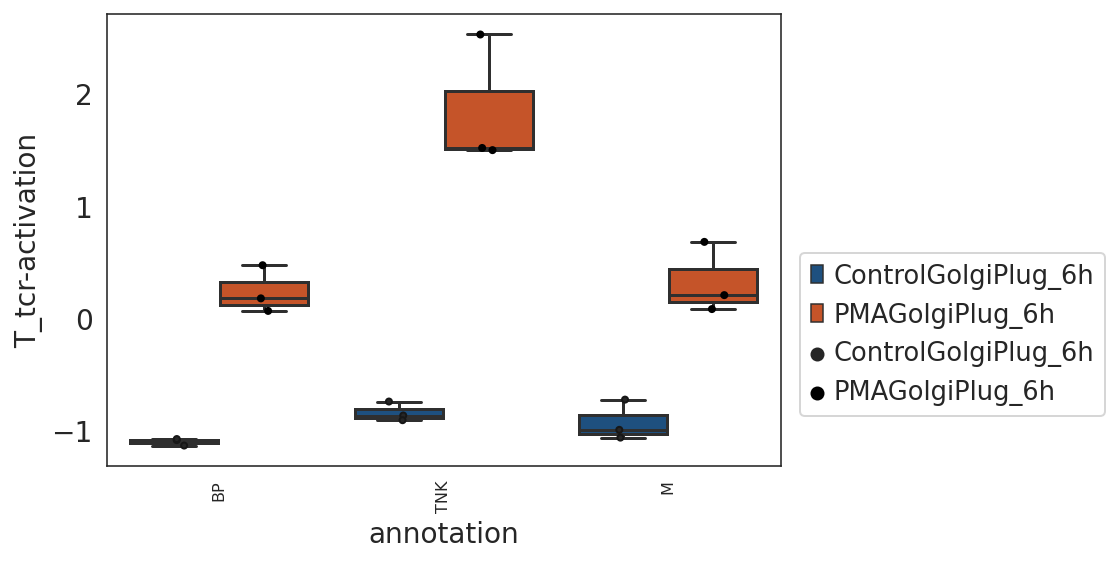

In [37]:
#plot
factor='T_tcr-activation'
save_name ='Kartha_celltype_TCR_boxplot_expimap'+factor+'softmask.svg'
hue_order = ['ControlGolgiPlug_6h','PMAGolgiPlug_6h']
sns.boxplot(data=plot_df_TCR,x='annotation', 
                y=factor, hue='Condition', order=['BP','TNK','M'], hue_order=hue_order, 
                orient=None, color=None, palette=blue_red, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=plot_df_TCR,x='annotation', 
                y=factor, hue='Condition', order=['BP','TNK','M'], hue_order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.xlim(-25,100)
plt.legend(bbox_to_anchor=[1.5, 0.5])
plt.xticks(rotation=90,size=8)
#plt.ylim(0,)
plt.savefig(fig_save_path+save_name)
plot_df.to_csv(fig_save_path + 'source_data/'+ save_name[:-4]+'.csv')
print(save_name)

In [38]:
plot_df_IFN = plot_df[plot_df['Condition'].isin(['IFNGolgiPlug_6h','ControlGolgiPlug_6h'])]
plot_df_IFN

,Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,T_tcr-activation,all_type-II-ifn-response
ControlGolgiPlug_6h_Donor1,-0.190435,ControlGolgiPlug_6h,BP,Donor1,-1.080928,0.144862
IFNGolgiPlug_6h_Donor1,-0.177082,IFNGolgiPlug_6h,BP,Donor1,-0.955056,0.111901
ControlGolgiPlug_6h_Donor2,-0.005815,ControlGolgiPlug_6h,BP,Donor2,-1.071338,0.094773
IFNGolgiPlug_6h_Donor3,0.138891,IFNGolgiPlug_6h,BP,Donor3,-1.248998,-0.151766
IFNGolgiPlug_6h_Donor2,-0.005635,IFNGolgiPlug_6h,BP,Donor2,-1.121007,-0.008847
ControlGolgiPlug_6h_Donor3,-0.011304,ControlGolgiPlug_6h,BP,Donor3,-1.129230,-0.002149
ControlGolgiPlug_6h_Donor1,-0.083379,ControlGolgiPlug_6h,TNK,Donor1,-0.862164,-0.008474
IFNGolgiPlug_6h_Donor1,0.054647,IFNGolgiPlug_6h,TNK,Donor1,-0.869964,0.006262
ControlGolgiPlug_6h_Donor2,0.006968,ControlGolgiPlug_6h,TNK,Donor2,-0.737977,0.079110
IFNGolgiPlug_6h_Donor3,0.102119,IFNGolgiPlug_6h,TNK,Donor3,-0.828345,-0.021380


/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#000000'` for same effect.
  warnings.warn(msg, FutureWarning)


Kartha_celltype_IFN_boxplot_expimapall_type-II-ifn-responsesoftmask.svg


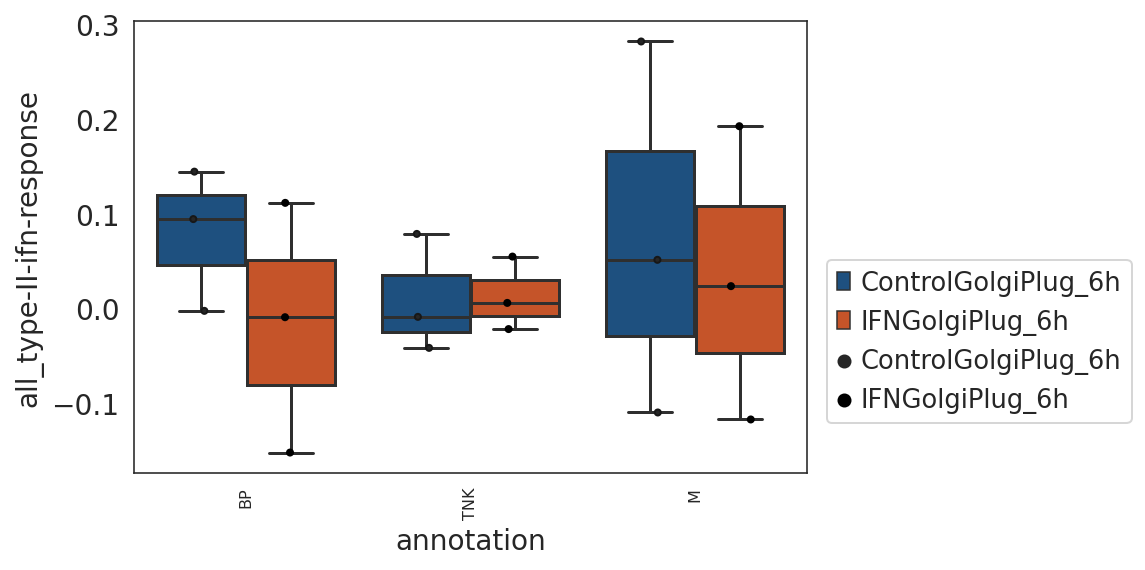

In [39]:
#plot
factor='all_type-II-ifn-response'
save_name ='Kartha_celltype_IFN_boxplot_expimap'+factor+'softmask.svg'
hue_order = ['ControlGolgiPlug_6h','IFNGolgiPlug_6h']
sns.boxplot(data=plot_df_IFN,x='annotation', 
                y=factor, hue='Condition', order=['BP','TNK','M'], hue_order=hue_order, 
                orient=None, color=None, palette=blue_red, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=plot_df_IFN,x='annotation', 
                y=factor, hue='Condition', order=['BP','TNK','M'], hue_order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.xlim(-25,100)
plt.legend(bbox_to_anchor=[1.5, 0.5])
#plt.ylim(0,)
plt.xticks(rotation=90,size=8)
plt.savefig(fig_save_path+save_name)
plot_df.to_csv(fig_save_path + 'source_data/'+ save_name[:-4]+'.csv')
print(save_name)

# expiMap (using all default settings)

Tutorial links (date April 27th 2023):
https://docs.scarches.org/en/latest/expimap_surgery_pipeline_basic.html
https://docs.scarches.org/en/latest/expimap_surgery_pipeline_advanced.html

Here we do not use the soft mask in expiMap which means that no new genes can be added to the gene sets. This approach is less comparable to Spectra which excels at discovering new genes involved in the gene programs linked to the input gene sets.

In [71]:
# model with all defaults params
#model
adata_path = DATA_DIR + 'PBMC-X-NA-X-Kartha-X-scRNAseq-X-10.1016_j.xgen.2022.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito_alldefault_new.h5ad'
#model
model_path = DATA_DIR + 'PBMC-X-NA-X-Kartha-X-scRNAseq-X-10.1016_j.xgen.2022.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito_alldefault_nonewnodes_new.pickle'
input_gene_sets = working_dir +'SPADE_genes_x_genesets.csv'


In [72]:
input_df = pd.read_csv(input_gene_sets)
input_df

,gs.name,g.name
0,all_multidrug-resistance,ABCC4
1,all_multidrug-resistance,ABCB4
2,all_multidrug-resistance,ABCC3
3,all_multidrug-resistance,ABCC1
4,all_porphyrine-heme_metabolism,UROS
...,...,...
7855,all_folate_metabolism,SLC19A1
7856,all_folate_metabolism,AMT
7857,all_folate_metabolism,FOLR3
7858,all_folate_metabolism,FTCD


In [73]:
adata = sc.read(adata_path)
adata

Only considering the two last: ['.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito_alldefault_new', '.h5ad'].
Only considering the two last: ['.100166_normalized_clustered_10000hv_batch_annotated_noribo_nomito_alldefault_new', '.h5ad'].


AnnData object with n_obs × n_vars = 23754 × 1841
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation', 'study'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm', 'highly_variable_intersection'
    uns: 'Condition_colors', 'Donor_colors', 'annotation_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'pheno_var_k40_colors', 'terms', 'tsne', 'umap'
    obsm: 'X_cvae', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'I', 'PCs'
    layers: 'imputed', 'raw'
    obsp: 'connectivities', 'distances'

In [74]:
import pickle
with open(model_path, 'rb') as f:
    q_intr_cvae = pickle.load(f)

In [75]:
q_intr_cvae.latent_directions(adata=adata)

In [76]:
adata.uns['terms']

array(['all_SASP', 'all_RIG-I-like-receptor_signaling',
       'all_oxidative-phosphorylation', 'all_mTORC1_signaling',
       'all_glycerophospholipid_metabolism',
       'all_wnt-beta-catenin-signaling', 'lung-epi_IL13_response',
       'NK_IL15_response', 'fibro_IL1B_response',
       'all_IL6-JAK-STAT3_signaling', 'all_JAK-STAT_signaling',
       'all_TLR_signaling', 'leuko_transendothelial-migration',
       'lung-smooth-muscle_TGFB1_response', 'all_GPI-anchor_synthesis',
       'all_citric-acid-cycle', 'all_macroautophagy',
       'M_mac_CSF1_response', 'all_ros_response', 'DC_LPS_response',
       'all_NOTCH_signaling', 'all_mitotic-spindle-component',
       'all_autophagy-of-mitochondria', 'all_MHC-II-presentation',
       'all_exocytosis', 'all_type-II-ifn-response',
       'all_PI3K-AKT-mTOR_signaling', 'all_TNF-via-NFkB_signaling',
       'all_osmotic-stress-response', 'endo_VEGFA_response',
       'fibro_EGF_response', 'all_steroid_metabolism', 'all_apoptosis',
       'all

In [77]:
gene_ls_ls = []
for i in list(adata.uns['terms']):
    gene_list =list(q_intr_cvae.term_genes(i, terms=adata.uns['terms'])['genes'][0:100])
    if len(q_intr_cvae.term_genes(i, terms=adata.uns['terms']))<100:
        add_number = 100-len(q_intr_cvae.term_genes(i, terms=adata.uns['terms']))
        gene_list = gene_list + add_number*[np.nan]
    gene_ls_ls.append(gene_list)

np.array(gene_ls_ls).shape

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['in_mask'][in_mask] = True
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['in_mask'][in_mask] = True
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['in_mask'][in_mask] = True
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['in_mask'][in_mask] = True
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['in_mask'][in_mask] = True
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['in_mask'][in_mask] = True
/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

(69, 100)

In [78]:
np.array(gene_ls_ls).shape

(69, 100)

In [79]:
import cytopus
G = cytopus.kb.KnowledgeBase()

KnowledgeBase object containing 75 cell types and 201 cellular processes



In [80]:
q_intr_cvae.term_genes(i, terms=adata.uns['terms'])['genes']

/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/scarches/models/expimap/expimap_model.py:348: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['in_mask'][in_mask] = True


Series([], Name: genes, dtype: float64)

In [81]:
overlap_df = cp.tl.label_marker_genes(np.array(gene_ls_ls), G.processes, threshold = 0.2)
overlap_df

,lung-epi_IL4_response,all_carnitine-shuttle,fibro_IGF1_response,p-DC_CpG-TLR9_response,all_autophagy_regulation_positive,B_IL2_response,all_SASP,all_fatty-acid-beta-oxidation-mitochondrial,all_PI3K-AKT-mTOR_signaling,all_eicosanoid_metabolism,...,all_amino-sugar-nucleotide-sugar_metabolism,all_GLU_metabolism,all_pentose-phosphate-pathway,all_galactose_metabolism,all_Beta-Ala_metabolism,DC_CD40L_response,Mac_LPS_response,all_autophagy-chaperone-mediated,all_nucleotide_metabolism,all_CYS_metabolism
all_SASP,0.028571,0.000,0.000000,0.0,0.028571,0.052632,1.000000,0.000000,0.028571,0.000000,...,0.0,0.00000,0.0,0.00,0.0,0.114286,0.000000,0.0000,0.000000,0.00
all_RIG-I-like-receptor_signaling,0.000000,0.000,0.000000,0.0,0.111111,0.000000,0.037037,0.000000,0.185185,0.000000,...,0.0,0.00000,0.0,0.00,0.0,0.074074,0.000000,0.0000,0.000000,0.00
all_oxidative-phosphorylation,0.000000,0.250,0.000000,0.0,0.012500,0.000000,0.000000,0.304348,0.000000,0.026316,...,0.0,0.04878,0.0,0.00,0.0,0.000000,0.013514,0.0000,0.000000,0.05
all_mTORC1_signaling,0.028571,0.000,0.028571,0.0,0.028571,0.000000,0.000000,0.000000,0.114286,0.000000,...,0.0,0.02439,0.1,0.05,0.0,0.000000,0.000000,0.0000,0.000000,0.10
all_glycerophospholipid_metabolism,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.043478,0.043478,...,0.0,0.00000,0.0,0.00,0.0,0.000000,0.000000,0.0000,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
all_macroautophagy_regulation_positive,0.000000,0.000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.138889,0.000000,...,0.0,0.00000,0.0,0.00,0.0,0.027778,0.000000,0.0625,0.000000,0.00
all_MYC_targets,0.086957,0.000,0.000000,0.0,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00000,0.0,0.00,0.0,0.000000,0.043478,0.0000,0.043478,0.00
Mac_LPS-IFNG_invitro_response,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.357143,0.000000,0.000000,0.000000,...,0.0,0.00000,0.0,0.00,0.0,0.285714,0.000000,0.0000,0.000000,0.00
all_peroxisome-component,0.000000,0.125,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,...,0.0,0.00000,0.0,0.00,0.0,0.000000,0.000000,0.0000,0.000000,0.00


In [82]:
adata.uns['terms']

array(['all_SASP', 'all_RIG-I-like-receptor_signaling',
       'all_oxidative-phosphorylation', 'all_mTORC1_signaling',
       'all_glycerophospholipid_metabolism',
       'all_wnt-beta-catenin-signaling', 'lung-epi_IL13_response',
       'NK_IL15_response', 'fibro_IL1B_response',
       'all_IL6-JAK-STAT3_signaling', 'all_JAK-STAT_signaling',
       'all_TLR_signaling', 'leuko_transendothelial-migration',
       'lung-smooth-muscle_TGFB1_response', 'all_GPI-anchor_synthesis',
       'all_citric-acid-cycle', 'all_macroautophagy',
       'M_mac_CSF1_response', 'all_ros_response', 'DC_LPS_response',
       'all_NOTCH_signaling', 'all_mitotic-spindle-component',
       'all_autophagy-of-mitochondria', 'all_MHC-II-presentation',
       'all_exocytosis', 'all_type-II-ifn-response',
       'all_PI3K-AKT-mTOR_signaling', 'all_TNF-via-NFkB_signaling',
       'all_osmotic-stress-response', 'endo_VEGFA_response',
       'fibro_EGF_response', 'all_steroid_metabolism', 'all_apoptosis',
       'all

In [83]:
#get factor names provided by expimap
overlap_df.index = adata.uns['terms']
overlap_df

,lung-epi_IL4_response,all_carnitine-shuttle,fibro_IGF1_response,p-DC_CpG-TLR9_response,all_autophagy_regulation_positive,B_IL2_response,all_SASP,all_fatty-acid-beta-oxidation-mitochondrial,all_PI3K-AKT-mTOR_signaling,all_eicosanoid_metabolism,...,all_amino-sugar-nucleotide-sugar_metabolism,all_GLU_metabolism,all_pentose-phosphate-pathway,all_galactose_metabolism,all_Beta-Ala_metabolism,DC_CD40L_response,Mac_LPS_response,all_autophagy-chaperone-mediated,all_nucleotide_metabolism,all_CYS_metabolism
all_SASP,0.028571,0.000,0.000000,0.0,0.028571,0.052632,1.000000,0.000000,0.028571,0.000000,...,0.0,0.00000,0.0,0.00,0.0,0.114286,0.000000,0.0000,0.000000,0.00
all_RIG-I-like-receptor_signaling,0.000000,0.000,0.000000,0.0,0.111111,0.000000,0.037037,0.000000,0.185185,0.000000,...,0.0,0.00000,0.0,0.00,0.0,0.074074,0.000000,0.0000,0.000000,0.00
all_oxidative-phosphorylation,0.000000,0.250,0.000000,0.0,0.012500,0.000000,0.000000,0.304348,0.000000,0.026316,...,0.0,0.04878,0.0,0.00,0.0,0.000000,0.013514,0.0000,0.000000,0.05
all_mTORC1_signaling,0.028571,0.000,0.028571,0.0,0.028571,0.000000,0.000000,0.000000,0.114286,0.000000,...,0.0,0.02439,0.1,0.05,0.0,0.000000,0.000000,0.0000,0.000000,0.10
all_glycerophospholipid_metabolism,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.043478,0.043478,...,0.0,0.00000,0.0,0.00,0.0,0.000000,0.000000,0.0000,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
all_macroautophagy_regulation_positive,0.000000,0.000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.138889,0.000000,...,0.0,0.00000,0.0,0.00,0.0,0.027778,0.000000,0.0625,0.000000,0.00
all_MYC_targets,0.086957,0.000,0.000000,0.0,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00000,0.0,0.00,0.0,0.000000,0.043478,0.0000,0.043478,0.00
Mac_LPS-IFNG_invitro_response,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.357143,0.000000,0.000000,0.000000,...,0.0,0.00000,0.0,0.00,0.0,0.285714,0.000000,0.0000,0.000000,0.00
all_peroxisome-component,0.000000,0.125,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,...,0.0,0.00000,0.0,0.00,0.0,0.000000,0.000000,0.0000,0.000000,0.00


In [84]:
#add latents to obs
terms = adata.uns['terms']
select_terms = list(adata.uns['terms'])
idx = []

for j in select_terms:
    for i,v in enumerate(terms):
        if v == j:
            idx.append(i)
            
            
            
latents = (q_intr_cvae.get_latent(adata.X, adata.obs['study'], mean=False) * adata.uns['directions'])[:, idx]


for i,v in enumerate(select_terms):
           adata.obs[v] = latents[:, i]

In [85]:
adata

AnnData object with n_obs × n_vars = 23754 × 1841
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation', 'study', 'all_SASP', 'all_RIG-I-like-receptor_signaling', 'all_oxidative-phosphorylation', 'all_mTORC1_signaling', 'all_glycerophospholipid_metabolism', 'all_wnt-beta-catenin-signaling', 'lung-epi_IL13_response', 'NK_IL15_response', 'fibro_IL1B_response', 'all_IL6-JAK-STAT3_signaling', 'all_JAK-STAT_signaling', 'all_TLR_signaling', 'leuko_transendothelial-migration', 'lung-smooth-muscle_TGFB1_response', 'all_GPI-anchor_synthesis', 'all_citric-acid-cycle', 'all_macroautophagy', 'M_mac_CSF1_response', 'all_ros_response', 'DC_LPS_response', 'all_NOTCH_signal

In [86]:
adata_celltype = adata[adata.obs['Condition'].isin(['ControlGolgiPlug_6h','IFNGolgiPlug_6h','LPSGolgiPlug_6h','PMAGolgiPlug_6h'])]
adata_celltype

View of AnnData object with n_obs × n_vars = 4486 × 1841
    obs: 'nCount_RNA', 'nFeature_RNA', 'Condition', 'StimType', 'Donor', 'pheno_k10', 'pheno_k20', 'pheno_k30', 'pheno_k40', 'pheno_k50', 'pheno_k60', 'pheno_k70', 'pheno_k80', 'pheno_k90', 'pheno_k100', 'pheno_var_k10', 'pheno_var_k20', 'pheno_var_k30', 'pheno_var_k40', 'pheno_var_k50', 'pheno_var_k60', 'pheno_var_k70', 'pheno_var_k80', 'pheno_var_k90', 'pheno_var_k100', 'annotation', 'study', 'all_SASP', 'all_RIG-I-like-receptor_signaling', 'all_oxidative-phosphorylation', 'all_mTORC1_signaling', 'all_glycerophospholipid_metabolism', 'all_wnt-beta-catenin-signaling', 'lung-epi_IL13_response', 'NK_IL15_response', 'fibro_IL1B_response', 'all_IL6-JAK-STAT3_signaling', 'all_JAK-STAT_signaling', 'all_TLR_signaling', 'leuko_transendothelial-migration', 'lung-smooth-muscle_TGFB1_response', 'all_GPI-anchor_synthesis', 'all_citric-acid-cycle', 'all_macroautophagy', 'M_mac_CSF1_response', 'all_ros_response', 'DC_LPS_response', 'all_NOTCH

In [87]:
adata_celltype.obs['batch'] = adata_celltype.obs['Condition'].str.cat(adata_celltype.obs['Donor'],sep='_')
adata_celltype.obs['batch']

/scratch/lsftmp/17667690.tmpdir/ipykernel_465130/3132211419.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_celltype.obs['batch'] = adata_celltype.obs['Condition'].str.cat(adata_celltype.obs['Donor'],sep='_')


cellBarcode
ControlGolgiPlug_6h_Donor1_ttgaggcacgagaaccgaacc    ControlGolgiPlug_6h_Donor1
ControlGolgiPlug_6h_Donor1_catgtatcaggcggacgtatt    ControlGolgiPlug_6h_Donor1
ControlGolgiPlug_6h_Donor1_cgattacattattctagtacc    ControlGolgiPlug_6h_Donor1
ControlGolgiPlug_6h_Donor1_attcgttctgcgcctatactt    ControlGolgiPlug_6h_Donor1
ControlGolgiPlug_6h_Donor1_agtaagcgtaatacaagttat    ControlGolgiPlug_6h_Donor1
                                                               ...            
PMAGolgiPlug_6h_Donor3_aaccacaacacgcgaaccaca            PMAGolgiPlug_6h_Donor3
PMAGolgiPlug_6h_Donor3_gtaatacaactcttacacgcg            PMAGolgiPlug_6h_Donor3
PMAGolgiPlug_6h_Donor3_ggcggaacgacactccaagct            PMAGolgiPlug_6h_Donor3
PMAGolgiPlug_6h_Donor3_acagtacaggacgtccaagct            PMAGolgiPlug_6h_Donor3
PMAGolgiPlug_6h_Donor3_cggtacgataggcaccaagct            PMAGolgiPlug_6h_Donor3
Name: batch, Length: 4486, dtype: object

First we will assess the factors which have been labeled by expiMap as by the input gene sets matching the perturbation

In [107]:
#the first gene set is labeled Mac_IFNG_response response but this is not correct (the gene set has been relabeled) it 
#is the same Mac_LPS-IFNG_invitro_response gene set used in the Spectra model)
factors_of_interest = ['Mac_LPS-IFNG_invitro_response','T_tcr-activation','all_type-II-ifn-response']

In [108]:
#mean exp per donor
plot_df_list = []

for i in set(adata_celltype.obs['annotation']):
    adata_celltype_sub = adata_celltype[adata_celltype.obs['annotation']==i]
    plot_df_list.append(aggregate_cell_scores(adata_celltype_sub,'Condition','annotation',factors_of_interest,'batch','Donor',
                            ['Condition','annotation','Donor'],
                            zero_cutoff =None))#0.00))
plot_df_list

[                            Mac_LPS-IFNG_invitro_response  \
 LPSGolgiPlug_6h_Donor1                           0.201024   
 ControlGolgiPlug_6h_Donor1                       0.105784   
 IFNGolgiPlug_6h_Donor1                           0.118143   
 ControlGolgiPlug_6h_Donor2                      -0.037465   
 PMAGolgiPlug_6h_Donor3                          -0.142310   
 IFNGolgiPlug_6h_Donor3                           0.139421   
 IFNGolgiPlug_6h_Donor2                          -0.175682   
 LPSGolgiPlug_6h_Donor3                          -0.170392   
 PMAGolgiPlug_6h_Donor1                           0.327444   
 ControlGolgiPlug_6h_Donor3                      -0.044108   
 PMAGolgiPlug_6h_Donor2                           0.152590   
 LPSGolgiPlug_6h_Donor2                          -0.054407   
 
                                       Condition annotation   Donor  \
 LPSGolgiPlug_6h_Donor1          LPSGolgiPlug_6h         BP  Donor1   
 ControlGolgiPlug_6h_Donor1  ControlGolgiPlug_6h  

In [109]:
plot_df = pd.concat(plot_df_list).fillna(0)
plot_df

,Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,T_tcr-activation,all_type-II-ifn-response
LPSGolgiPlug_6h_Donor1,0.201024,LPSGolgiPlug_6h,BP,Donor1,-0.548925,-0.436545
ControlGolgiPlug_6h_Donor1,0.105784,ControlGolgiPlug_6h,BP,Donor1,-0.829573,-1.184273
IFNGolgiPlug_6h_Donor1,0.118143,IFNGolgiPlug_6h,BP,Donor1,-1.017496,-0.465807
ControlGolgiPlug_6h_Donor2,-0.037465,ControlGolgiPlug_6h,BP,Donor2,-0.673880,-0.673231
PMAGolgiPlug_6h_Donor3,-0.142310,PMAGolgiPlug_6h,BP,Donor3,0.414678,-0.385898
IFNGolgiPlug_6h_Donor3,0.139421,IFNGolgiPlug_6h,BP,Donor3,-1.018914,-0.161926
IFNGolgiPlug_6h_Donor2,-0.175682,IFNGolgiPlug_6h,BP,Donor2,-0.894696,0.313734
LPSGolgiPlug_6h_Donor3,-0.170392,LPSGolgiPlug_6h,BP,Donor3,-0.911024,-0.175496
PMAGolgiPlug_6h_Donor1,0.327444,PMAGolgiPlug_6h,BP,Donor1,0.922854,-0.260698
ControlGolgiPlug_6h_Donor3,-0.044108,ControlGolgiPlug_6h,BP,Donor3,-0.915625,-1.405481


In [110]:
plot_df_LPS = plot_df[plot_df['Condition'].isin(['LPSGolgiPlug_6h','ControlGolgiPlug_6h'])]
plot_df_LPS

,Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,T_tcr-activation,all_type-II-ifn-response
LPSGolgiPlug_6h_Donor1,0.201024,LPSGolgiPlug_6h,BP,Donor1,-0.548925,-0.436545
ControlGolgiPlug_6h_Donor1,0.105784,ControlGolgiPlug_6h,BP,Donor1,-0.829573,-1.184273
ControlGolgiPlug_6h_Donor2,-0.037465,ControlGolgiPlug_6h,BP,Donor2,-0.673880,-0.673231
LPSGolgiPlug_6h_Donor3,-0.170392,LPSGolgiPlug_6h,BP,Donor3,-0.911024,-0.175496
ControlGolgiPlug_6h_Donor3,-0.044108,ControlGolgiPlug_6h,BP,Donor3,-0.915625,-1.405481
LPSGolgiPlug_6h_Donor2,-0.054407,LPSGolgiPlug_6h,BP,Donor2,-0.587064,-0.227133
LPSGolgiPlug_6h_Donor1,-0.031060,LPSGolgiPlug_6h,TNK,Donor1,-0.584610,-0.280665
ControlGolgiPlug_6h_Donor1,0.015681,ControlGolgiPlug_6h,TNK,Donor1,-1.081581,-0.685214
ControlGolgiPlug_6h_Donor2,0.043645,ControlGolgiPlug_6h,TNK,Donor2,-0.986140,-0.256750
LPSGolgiPlug_6h_Donor3,0.073677,LPSGolgiPlug_6h,TNK,Donor3,-1.039585,0.055062


/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#000000'` for same effect.
  warnings.warn(msg, FutureWarning)


Kartha_celltype_LPS_boxplot_expimapMac_LPS-IFNG_invitro_response.svg


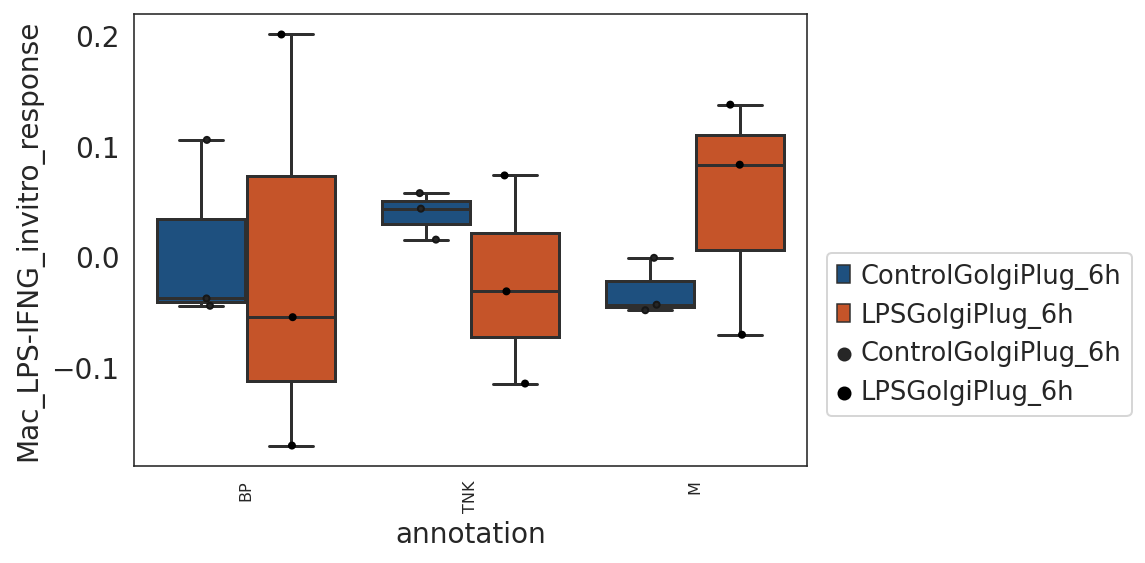

In [104]:
#plot
%matplotlib inline
sns.set_style('white')
factor='Mac_LPS-IFNG_invitro_response' 
save_name ='Kartha_celltype_LPS_boxplot_expimap'+factor+'.svg'
hue_order = ['ControlGolgiPlug_6h','LPSGolgiPlug_6h']
sns.boxplot(data=plot_df_LPS,x='annotation', 
                y=factor, hue='Condition', order=['BP','TNK','M'], hue_order=hue_order, 
                orient=None, color=None, palette=blue_red, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=plot_df_LPS,x='annotation', 
                y=factor, hue='Condition', order=['BP','TNK','M'], hue_order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.xlim(-25,100)
plt.legend(bbox_to_anchor=[1.5, 0.5])
plt.xticks(rotation=90,size=8)
#plt.ylim(0,)
plt.savefig(fig_save_path+save_name)
plot_df.to_csv(fig_save_path + 'source_data/'+ save_name[:-4]+'.csv')
print(save_name)

In [93]:
plot_df_TCR = plot_df[plot_df['Condition'].isin(['PMAGolgiPlug_6h','ControlGolgiPlug_6h'])]
plot_df_TCR

,Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,T_tcr-activation,all_type-II-ifn-response
ControlGolgiPlug_6h_Donor1,0.105784,ControlGolgiPlug_6h,BP,Donor1,-0.829573,-1.184273
ControlGolgiPlug_6h_Donor2,-0.037465,ControlGolgiPlug_6h,BP,Donor2,-0.673880,-0.673231
PMAGolgiPlug_6h_Donor3,-0.142310,PMAGolgiPlug_6h,BP,Donor3,0.414678,-0.385898
PMAGolgiPlug_6h_Donor1,0.327444,PMAGolgiPlug_6h,BP,Donor1,0.922854,-0.260698
ControlGolgiPlug_6h_Donor3,-0.044108,ControlGolgiPlug_6h,BP,Donor3,-0.915625,-1.405481
PMAGolgiPlug_6h_Donor2,0.152590,PMAGolgiPlug_6h,BP,Donor2,0.855366,-0.022254
ControlGolgiPlug_6h_Donor1,0.015681,ControlGolgiPlug_6h,TNK,Donor1,-1.081581,-0.685214
ControlGolgiPlug_6h_Donor2,0.043645,ControlGolgiPlug_6h,TNK,Donor2,-0.986140,-0.256750
PMAGolgiPlug_6h_Donor3,0.029516,PMAGolgiPlug_6h,TNK,Donor3,1.703361,0.771292
PMAGolgiPlug_6h_Donor1,-0.040018,PMAGolgiPlug_6h,TNK,Donor1,1.676231,0.379261


/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#000000'` for same effect.
  warnings.warn(msg, FutureWarning)


Kartha_celltype_TCR_boxplot_expimapT_tcr-activation.svg


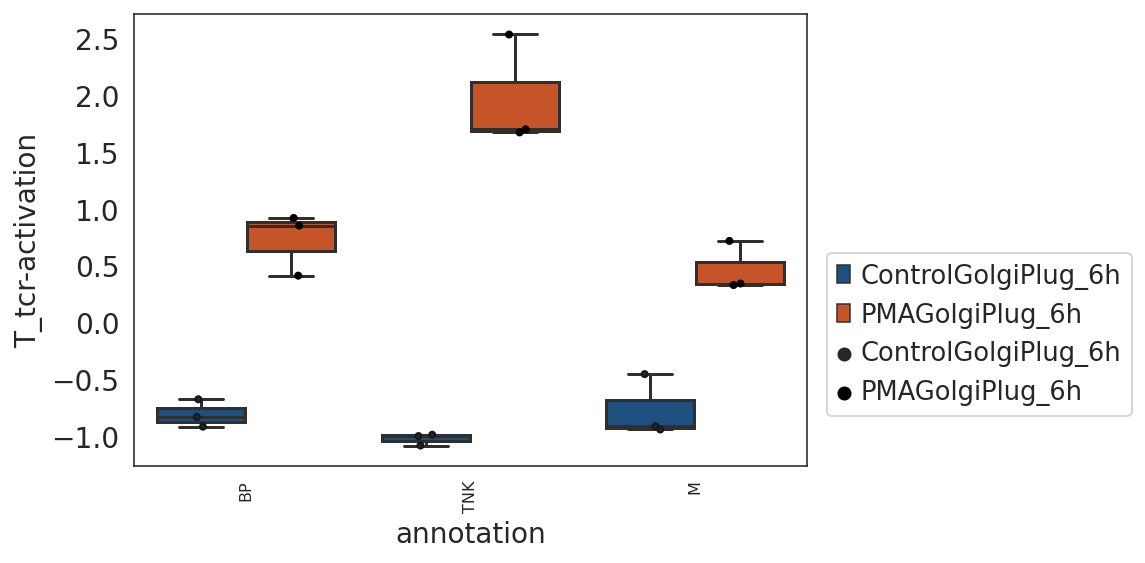

In [95]:
#plot
factor='T_tcr-activation'
save_name ='Kartha_celltype_TCR_boxplot_expimap'+factor+'.svg'
hue_order = ['ControlGolgiPlug_6h','PMAGolgiPlug_6h']
sns.boxplot(data=plot_df_TCR,x='annotation', 
                y=factor, hue='Condition', order=['BP','TNK','M'], hue_order=hue_order, 
                orient=None, color=None, palette=blue_red, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=plot_df_TCR,x='annotation', 
                y=factor, hue='Condition', order=['BP','TNK','M'], hue_order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.xlim(-25,100)
plt.legend(bbox_to_anchor=[1.5, 0.5])
plt.xticks(rotation=90,size=8)
#plt.ylim(0,)
plt.savefig(fig_save_path+save_name)
plot_df.to_csv(fig_save_path + 'source_data/'+ save_name[:-4]+'.csv')
print(save_name)

In [96]:
fold_changes = []
celltype = list(set(plot_df_TCR['annotation']))
for i in celltype:
    plot_df_TCR_subset = plot_df_TCR[plot_df_TCR['annotation']==i]
    fold_changes_cell = []
    for j in set(plot_df_TCR_subset['Donor']):
        plot_df_TCR_subset_celltype = plot_df_TCR_subset[plot_df_TCR_subset['Donor']==j]
        b = list(plot_df_TCR_subset_celltype[plot_df_TCR_subset_celltype['Condition']=='ControlGolgiPlug_6h']['T_tcr-activation'])[0]
        a = list(plot_df_TCR_subset_celltype[plot_df_TCR_subset_celltype['Condition']!='ControlGolgiPlug_6h']['T_tcr-activation'])[0]
        if a!=0 and b!=0:
            fold_changes_cell.append(a/b)
        elif a==0 and b==0:
            print('for',i,j,'both values are 0')
        else:
            print('check your data')
    fold_changes.append(fold_changes_cell)

In [99]:
plot_df_IFN = plot_df[plot_df['Condition'].isin(['IFNGolgiPlug_6h','ControlGolgiPlug_6h'])]
plot_df_IFN

,Mac_LPS-IFNG_invitro_response,Condition,annotation,Donor,T_tcr-activation,all_type-II-ifn-response
ControlGolgiPlug_6h_Donor1,0.105784,ControlGolgiPlug_6h,BP,Donor1,-0.829573,-1.184273
IFNGolgiPlug_6h_Donor1,0.118143,IFNGolgiPlug_6h,BP,Donor1,-1.017496,-0.465807
ControlGolgiPlug_6h_Donor2,-0.037465,ControlGolgiPlug_6h,BP,Donor2,-0.673880,-0.673231
IFNGolgiPlug_6h_Donor3,0.139421,IFNGolgiPlug_6h,BP,Donor3,-1.018914,-0.161926
IFNGolgiPlug_6h_Donor2,-0.175682,IFNGolgiPlug_6h,BP,Donor2,-0.894696,0.313734
ControlGolgiPlug_6h_Donor3,-0.044108,ControlGolgiPlug_6h,BP,Donor3,-0.915625,-1.405481
ControlGolgiPlug_6h_Donor1,0.015681,ControlGolgiPlug_6h,TNK,Donor1,-1.081581,-0.685214
IFNGolgiPlug_6h_Donor1,0.068056,IFNGolgiPlug_6h,TNK,Donor1,-0.914699,-0.598672
ControlGolgiPlug_6h_Donor2,0.043645,ControlGolgiPlug_6h,TNK,Donor2,-0.986140,-0.256750
IFNGolgiPlug_6h_Donor3,-0.040640,IFNGolgiPlug_6h,TNK,Donor3,-0.795065,-0.086007


/home/wallet/miniconda3/envs/2023_scarches/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:#000000'` for same effect.
  warnings.warn(msg, FutureWarning)


Kartha_celltype_IFN_boxplot_expimapall_type-II-ifn-response.svg


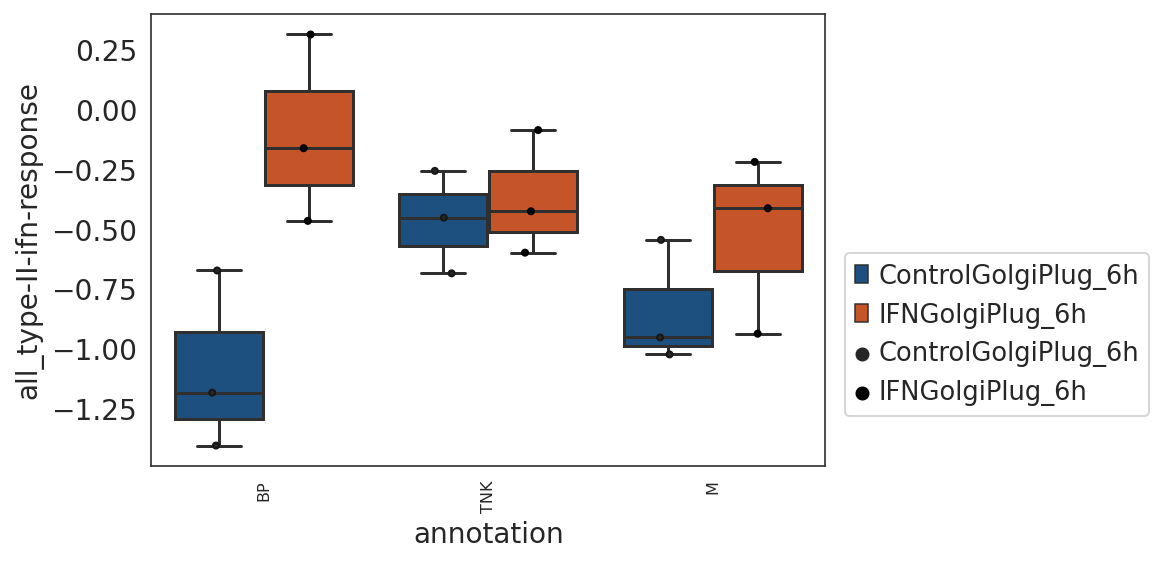

In [100]:
#plot
factor='all_type-II-ifn-response'
save_name ='Kartha_celltype_IFN_boxplot_expimap'+factor+'.svg'
hue_order = ['ControlGolgiPlug_6h','IFNGolgiPlug_6h']
sns.boxplot(data=plot_df_IFN,x='annotation', 
                y=factor, hue='Condition', order=['BP','TNK','M'], hue_order=hue_order, 
                orient=None, color=None, palette=blue_red, saturation=0.75, width=0.8, 
                dodge=True, fliersize=0, linewidth=None, whis=1.5, ax=None)
sns.stripplot(data=plot_df_IFN,x='annotation', 
                y=factor, hue='Condition', order=['BP','TNK','M'], hue_order=hue_order, 
                orient=None, color='#000000',s=3,
                dodge=True, linewidth=None, ax=None)
#plt.xlim(-25,100)
plt.legend(bbox_to_anchor=[1.5, 0.5])
#plt.ylim(0,)
plt.xticks(rotation=90,size=8)
plt.savefig(fig_save_path+save_name)
plot_df.to_csv(fig_save_path + 'source_data/'+ save_name[:-4]+'.csv')
print(save_name)